# Plots for the Teachable Robot Project

# Useful Functions

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
data_dirs = [
    pathlib.Path('meta-mb-internal/data'),
    pathlib.Path('meta-mb-internal/old_data'),
    pathlib.Path('meta-mb-internal'),
]

def get_filenames(name):
    name = str(name)
    name_paths = []
    for data_dir in data_dirs:
        for exp_dir in data_dir.iterdir():
            if name in exp_dir.name:
                name_paths.append(exp_dir)
    return name_paths

def plot_curriculum(data_names, x_type, use_min_len=True):
    color = iter(cm.rainbow(np.linspace(0, 1, len(data_names))))
    legend = []
    legend_colors = []
    plots = []
    df_y_key = 'Curriculum Percent'
    if x_type == 'samples':
        x_label = 'Samples'
        df_x_key = 'Itr'
        title = 'Sample Efficiency'
    elif x_type == 'feedback':
        x_label = 'Num Feedback'
        df_x_key = 'Train/NumFeedbackTotal'
        title = 'Feedback Efficiency'
        
    for run_names, legend_name in data_names:
        try:
            data = [d for run_name in run_names for d in load_data(run_name)]

            cols = [df[df_y_key].to_numpy() for df in data]
            c = next(color)
            for i, run in enumerate(cols):
                x_val = data[i][df_x_key].to_numpy()
                good_indices = np.argwhere(~np.isnan(x_val))[:, 0]
                plt.plot(x_val[good_indices], run[good_indices], c=c)
            legend_line = mlines.Line2D([], [], color=c, label=legend_name)
            plots.append(legend_line)
        except Exception as e:
            print(e)
            print("couldn't plot " + legend_name)

    plt.title(title)
    plt.ylabel('Curriculum %')
    plt.ylim(0, 1)
    plt.xlabel(x_label)
    plt.legend(handles=plots)
    plt.show()


def load_data(name, file_name='progress.csv'):
    name_paths = get_filenames(name)
    assert len(name_paths) > 0, "No files found with name " + name
    # check that they're all the same except the seed
    csv_datas = []
    for path in name_paths:
        assert path.name[:-1] == name_paths[0].name[:-1], f"Found multiple files with name {name}: {[path.name for path in name_paths]}"
        try:
            csv_name = path.joinpath(file_name)
            data = pd.read_csv(csv_name)
#             print("READ CSV!")
#             print(data.columns)
        except Exception as e:
            print(e)
            csv_name = path.joinpath('new_progress.csv')
            data = pd.read_csv(csv_name)
            
        # There used to be a bug where reward wasn't computed correctly
        if name in ['0729_PA', '0730']:
            gave_reward_indices = np.argwhere(~np.isnan(data['Train/num_feedback_reward'].to_numpy()))[:, 0]
            # Assume for each null run, we're collecting as much as in the last valid run
            num_advice = data['Train/num_feedback_advice'].fillna(method='ffill').to_numpy()
            total_advice = np.cumsum(num_advice)
            # Assume for each run where num_feedback_reward is not None we got one reward per sample
            num_reward = np.zeros_like(data['Train/num_feedback_reward'])
            num_reward[gave_reward_indices] = 800
            total_reward = np.cumsum(num_reward)
            data['Train/num_feedback_advice'] = num_advice
            data['Train/num_feedback_reward'] = num_reward
            data['Train/NumFeedbackReward'] = total_reward
            data['Train/NumFeedbackAdvice'] = total_advice
            data['Train/NumFeedbackTotal'] = total_advice + total_reward
#         elif 'Train/num_feedback_advice' in data.columns and 'Train/num_feedback_reward' in data.columns:
#             data['Train/num_feedback_reward'] = data['Train/num_feedback_reward'] * 0 + 800
#             data['Train/NumFeedbackAdvice'] = np.cumsum(data['Train/num_feedback_advice'])
#             data['Train/NumFeedbackReward'] = np.cumsum(data['Train/num_feedback_reward'])
#             timestep_feedback = data['Train/num_feedback_advice'] + data['Train/num_feedback_reward']
#             full_feedback = np.cumsum(timestep_feedback)
#             data['Train/NumFeedbackTotal'] = full_feedback
        csv_datas.append(data)
    return csv_datas

def plot_final_generalization(runs, title):
    legend_list = []
    env_names = None
    env_dict = {}
    for run_names, legend_name in runs:
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name, file_name='results.csv')
            if env_names is None:
                env_names = data[0][' env'].to_numpy()
                env_dict = {env_name: ([],[]) for env_name in env_names}
            success = [df['success_rate'].to_numpy() for df in data]
            for i, (env_name, (mean_list, std_list)) in enumerate(env_dict.items()):
                mean_list.append(np.mean([s[i].item() for s in success]))
                std_list.append(np.std([s[i].item() for s in success]))
            legend_list.append(legend_name)
        except Exception as e:
            print("Error on ", run_names, e)
                                
    for env_name, (mean_list, std_list) in env_dict.items():
        plt.title(title + ' - ' + env_name)
        plt.bar(legend_list, mean_list, yerr=std_list, capsize=5)
        plt.xticks(rotation=45)
        plt.show()

def plot_curriculum_generalization(runs, title):
    for run_names, legend_name in runs:  # Currently plotting each one separately.
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name, file_name='results.csv')
            levels = sorted(np.unique(data[0]['policy']))
            print("LEVELS", levels)
            for level in levels:
                relevant_data = [df[df['policy'] == level] for df in data]
                x = relevant_data[0][' env']
                y_data = [df['success_rate'].to_numpy() for df in relevant_data]
                y_mean = y_data[0]
                y_err = np.zeros_like(y_mean)
                y_mean = [np.mean([y[i] for y in y_data]) for i in range(len(y_data[0]))]
                y_err = [np.std([y[i] for y in y_data]) for i in range(len(y_data[0]))]
                plt.title(title + ' - ' + level)
                plt.bar(x, y_mean, yerr=y_err, capsize=5)
                plt.xticks(rotation=90)
                plt.show()
        except Exception as e:
            print("Error on ", run_names, e)

        
def plot_leaderboard(methods):
    plot_values = []
    error_bars = []
    plot_names = []
    num_feedback_key = 'Train/NumFeedbackTotal'
    for run_names, legend_name, _ in methods:
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name)
            if run_name in ['0577', '0578']:  # TODO: delete this later now that we've fixed how we count feedback
                pure_feedback_list = [df['Train/NumFeedbackAdvice'].to_numpy()[-2].item() for df in data]
                reward_list = [df['Train/NumFeedbackReward'].to_numpy()[-2].item() for df in data]
                path_length_list = [df['Train/PathLength'].to_numpy()[-2].item() for df in data]
                success_list = [df['Train/Success'].to_numpy()[-2].item() for df in data]
                num_feedback_list = [pure_feedback + reward_feedback / path_length * success_rate for reward_feedback, path_length, success_rate, pure_feedback in zip(reward_list, path_length_list, success_list, pure_feedback_list)]
            else:
                num_feedback_list = [df[num_feedback_key].to_numpy()[-2].item() for df in data]
            plot_values.append(np.mean(num_feedback_list))
            error_bars.append(np.std(num_feedback_list))
            plot_names.append(f'{run_name} - {legend_name}')
        except Exception as e:
            print(e)
            print("couldn't plot " + legend_name)
    plt.bar(plot_names, plot_values, yerr=error_bars, capsize=5)
    plt.xticks(rotation=45)
    plt.show()

# NOTE: this is just here temporarily to make the csvs parsable b/c of a bug.
# The bug is fixed now, so once the current runs become unnecessary (or have all been fixed) we can delete this
def fix_csv(filename):
    data_folder = get_filenames(filename)[0]
    correct_data = []
    csv = data_folder.joinpath('progress.csv')
    new_csv = data_folder.joinpath('new_progress.csv')
    print(csv)
    with open(csv, 'r') as f:
        for line in f.readlines():
            if 'BufferSize' in line:
                correct_data = []
            correct_data.append(line)
    with open(new_csv, 'w') as f:
        f.writelines(correct_data)
            
for num in range(677, 679):
    fix_csv(num)
# # fix_csv(557)


# runs = [
#     (['EVAL_539', 'EVAL_540'], 'PA'),
# #     (['0577', '0578'], 'PA - Sparse'),
#     (['0627', '0628'], 'PA - Distill'),
#     (['0706', '0707'], 'PA - Self-Distill'),
#     (['0677', '0678'], 'PA - No 10 Rule'),
#     (['0655'], 'PA - BCS'),
#     (['692', '693'], 'PA - Big Batch No Distill'),
#     (['698', '699'], 'PA - Big Batch Distill'),
# ]
# plot_final_generalization(runs, 'Eval with Teacher')

meta-mb-internal/old_data/677/progress.csv
meta-mb-internal/old_data/678/progress.csv


# <font color='green'>Claim 0: Feedback helps the agent learn more quickly (no distillation)</font>
## <font color='green'> [Status: working, probably good enough!] </font>


## <font color='green'>[STATUS] - Good enough, although there may be room for improvement</font>

This should be true, so long as the feedback contains any useful information.

### GOOD NEWS: All teachers outperform no teacher.

Subgoal can't get through the curriculum, but this is fine b/c we are able to ground Subgoals through bootstrapping (see claim 6).

### Next steps: It seems like self-distillation helps a LOT, so replace the current runs with self-distillation runs (and use whatever the current model-size/batch-size exps say is the best batch size). Also, don't use the 10-rule.

## <font color='green'>[MAIN] Comparing the Feedback Efficiency of Different Teachers (no bootstrapping or anything) </green>

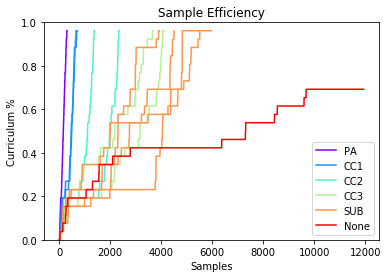

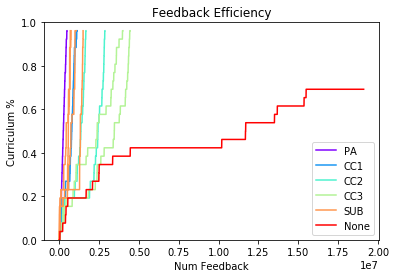

In [4]:
data_names = [
    (['0540'], 'PA'),
#     (['0577', '0578'], 'PA22'),
    (['0541', '0542'], 'CC1'),
    (['0543', '0544'], 'CC2'),
    (['0545', '0546'], 'CC3'),
    (['0722', '0723', '688'], 'SUB'),
#     (['0547', '0548'], 'SUB'),
    (['0481'], 'None'),
]

plot_curriculum(data_names, 'samples')

plot_curriculum(data_names, 'feedback')

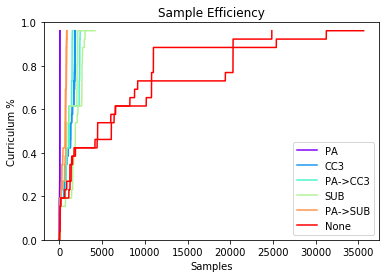

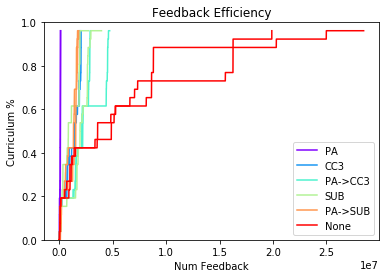

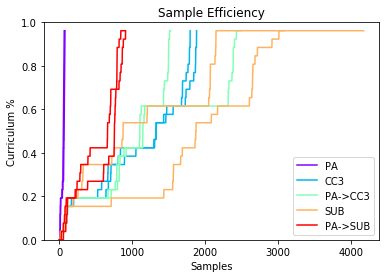

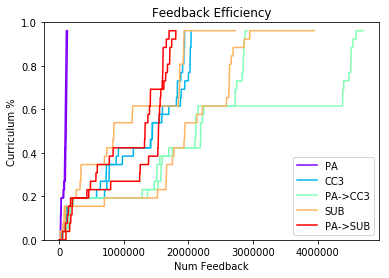

In [5]:
data_names = [ 
    (['0877', '0878'], 'PA'),
    (['0885', '0886'], 'CC3'),
    (['0895', '0896'], 'PA->CC3'),
    (['0887', '0888'], 'SUB'),
    (['0897', '0898'], 'PA->SUB'),
    (['0883', '0884'], 'None'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

# SAME, but no NONE
data_names = [ 
    (['0877', '0878'], 'PA'),
    (['0885', '0886'], 'CC3'),
    (['0895', '0896'], 'PA->CC3'),
    (['0887', '0888'], 'SUB'),
    (['0897', '0898'], 'PA->SUB'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

## <font color='green'>[HELPER] How close are we to the "best case" feedback efficiency (i.e. IL from oracle)</font>

Next steps: Once we re-run the RL runs with no 10-rule, replace them here.

If we're close, it's probably not worth trying to make the RL training process much more efficient.

(Is this the best case? I'm assuming IL > RL, but maybe not always true?)

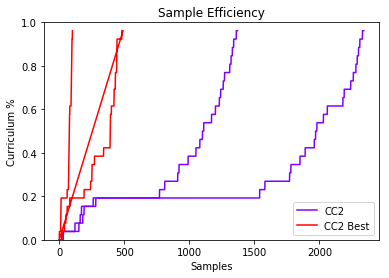

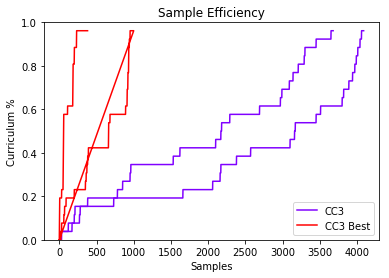

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77



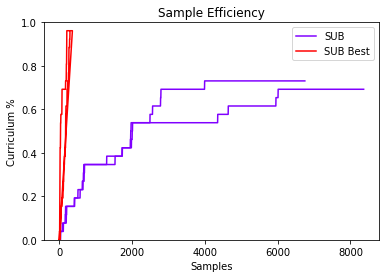

In [6]:
# NOTE: 'Best' runs didn't have the 10-rule, others did
data_names = [
    (['0543', '0544'], 'CC2'),
    (['0656'], 'CC2 Best'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0545', '0546'], 'CC3'),
    (['658'], 'CC3 Best'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0547', '0548'], 'SUB'),
    (['0660'], 'SUB Best'),
]
plot_curriculum(data_names, 'samples')

## <font color='green'> [HELPER] Does dropping instructions help? </font>

Understore_I means no instructions.

Conclusion: No real difference for most teachers. Possible improvmeent for SUB, but also may just be b/c we trained longer.

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77



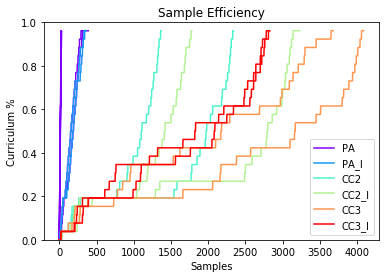

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77



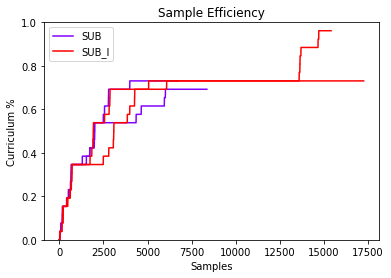

In [7]:
data_names = [
    (['0539', '0540'], 'PA'),
    (['0597', '0598'], 'PA_I'),
    (['0543', '0544'], 'CC2'),
    (['0579', '0580'], 'CC2_I'),
    (['0545', '0546'], 'CC3'),
    (['0581', '0582'], 'CC3_I'),
]

plot_curriculum(data_names, 'samples')


data_names = [
    (['0547', '0548'], 'SUB'),
    (['0599', '0600'], 'SUB_I'),
]

plot_curriculum(data_names, 'samples')

# <font color='blue'> Claim 1: Feedback helps the agent learn more quickly (distillation) </font>
## <font color='blue'> [Status: hard teachers get stuck, and no teachers outperform PA yet!] </font>



## <font color='blue'>[STATUS] - Need to work on sample-efficiency.</font>


If this isn't true for certain higher-level teachers that's fine, so long as we are able to show that the problem is grounding, but once grounded it does work better.

### GOOD NEWS: All agents trained with feedback outperform no teacher.

### BAD NEWS: Agents trained with complex teachers have a hard time completing the curriculum.

## <font color='blue'>[MAIN] Feedback Efficiency of Different Teachers </font>

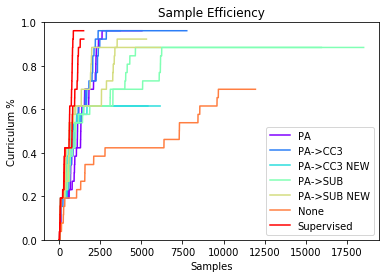

'Train/NumFeedbackTotal'
couldn't plot Supervised


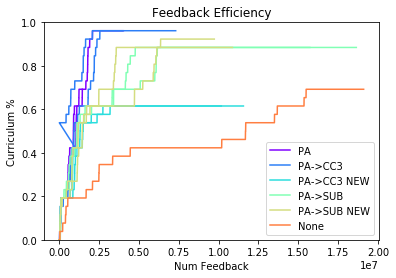

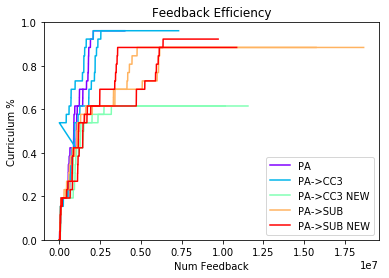

In [8]:
# OLD ENTROPY -seems to do better with .001
data_names = [  # TODO: re-run these 
    (['0627', '0628'], 'PA'),
#     (['0753', '0754'], 'PA2'),
#     (['0629', '0630'], 'CC1'),
#     (['0631', '0632'], 'CC2'),
#     (['0633', '0634'], 'CC3'),
    (['0666', '0667'], 'PA->CC3'),
    (['0825', '0826'], 'PA->CC3 NEW'),
#     (['0635', '0636'], 'SUB'),
    (['0668', '0669'], 'PA->SUB'),
    (['827', '828'], 'PA->SUB NEW'),
#     (['0664'], 'SUB BIG'),
    (['0481'], 'None'),
    (['0623', '0624'], 'Supervised'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')
data_names = data_names[:-2]
# Same as before, but no None so it rescales
plot_curriculum(data_names, 'feedback')
# TODO: plot TotalNumFeedback during collection so we get it even when doing supervised runs

Found multiple files with name 869: ['869', 'EVAL_869_NOFINETUNE']
couldn't plot PA->CC3


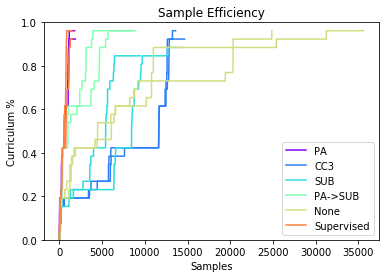

Found multiple files with name 869: ['869', 'EVAL_869_NOFINETUNE']
couldn't plot PA->CC3
'Train/NumFeedbackTotal'
couldn't plot Supervised


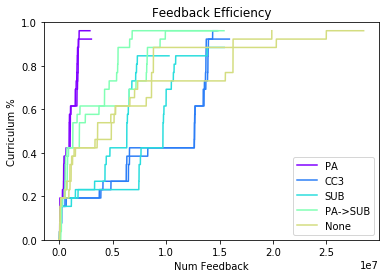

Found multiple files with name 869: ['869', 'EVAL_869_NOFINETUNE']
couldn't plot PA->CC3


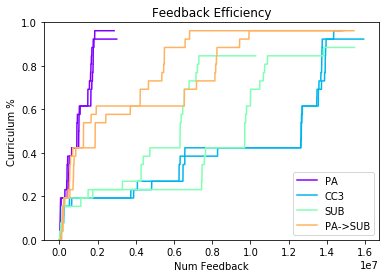

In [9]:
data_names = [  # TODO: re-run these 
    (['867', '868'], 'PA'),
    (['0889', '0890'], 'CC3'),
    (['869', '870'], 'PA->CC3'),
    (['0891', '0892'], 'SUB'),
    (['871', '872'], 'PA->SUB'),
    (['0883', '0884'], 'None'),
    (['0623', '0624'], 'Supervised'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')
data_names = data_names[:-2]
# Same as before, but no None so it rescales
plot_curriculum(data_names, 'feedback')
# TODO: plot TotalNumFeedback during collection so we get it even when doing supervised runs

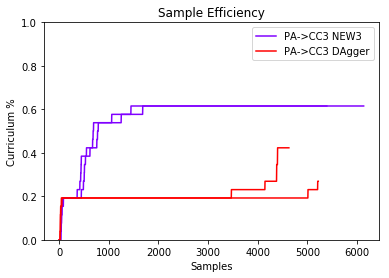

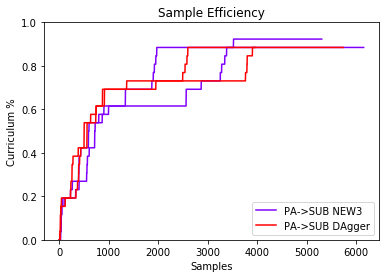

In [10]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0825', '0826'], 'PA->CC3 NEW3'),
    (['084_', '842'], 'PA->CC3 DAgger'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['827', '828'], 'PA->SUB NEW3'),
    (['843', '844'], 'PA->SUB DAgger'), #844
]
plot_curriculum(data_names, 'samples')


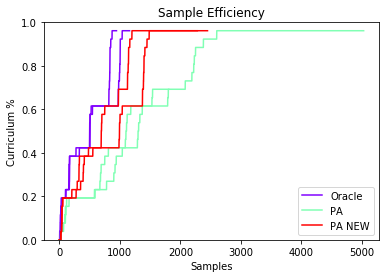

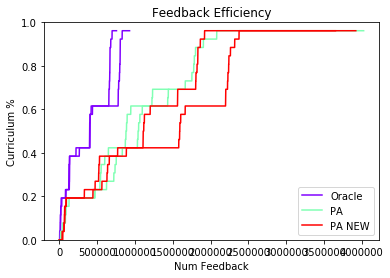

In [11]:
# HOW CLOSE IS PA DISTILL TO ORACLE DISTILL?
data_names = [  # TODO: re-run these 
    (['799', '800'], 'Oracle'),
    (['0627', '0628'], 'PA'),
    (['0753', '0754'], 'PA NEW'),
#     (['0787', '0788'], 'PA NEW2'),
#     (['0759', '0760'], 'PA PRETRAINED'),
#     (['0793', '0794'], 'PA PRETRAINED2'),
#     (['801', '802'], 'PA Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')



## <font color='blue'>[HELPER] How close are we to the "best case" feedback efficiency (i.e. distill from pretrained model)</font>

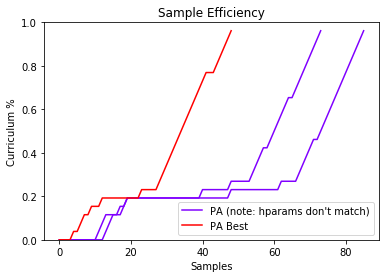

Found multiple files with name 659: ['T0659_CURRICULUM1_CC3_BCS_teacherCartesianCorrections_SAME_SD_dense_threshS0.99_threshA0.6_lr0.0001_ent0.0001_currfnone_hot_2', 'EVAL_659_NOFINETUNE']
couldn't plot CC3 Best


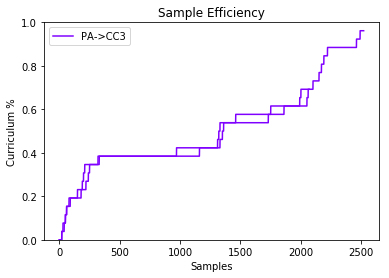

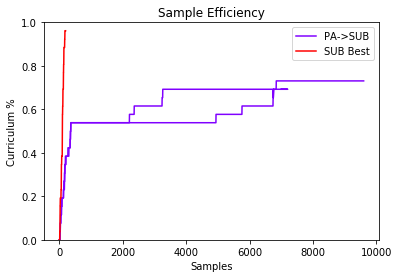

In [12]:
# NO DISTILLATION TO NO TEACHER (collect oracle, distill to teacher)
data_names = [
    (['0779', '0780'], "PA (note: hparams don't match)"),
    (['0655'], 'PA Best'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['639', '640'], 'PA->CC3'),
    (['659'], 'CC3 Best'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['641', '642'], 'PA->SUB'),
    (['661'], 'SUB Best'),
]
plot_curriculum(data_names, 'samples')

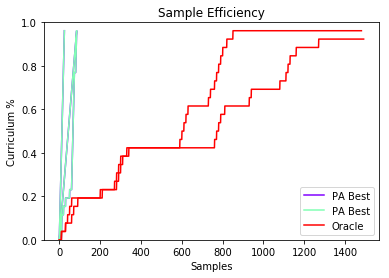

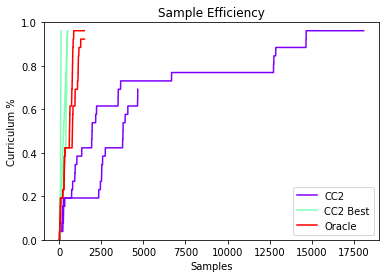

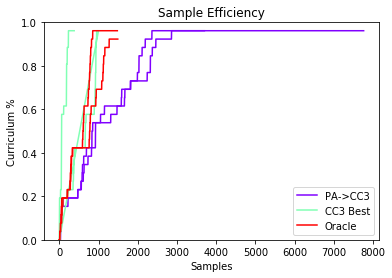

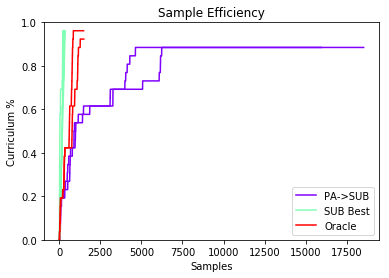

In [13]:
# YES DISTILLATION (collect with pretrained model, distill to no teacher)
# NOTE: HPARAMs are out of date
    
data_names = [
    (['0654'], 'PA Best'),
    (['0654'], 'PA Best'),
    (['0623', '0624'], 'Oracle'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0631', '0632'], 'CC2'),
    (['0656'], 'CC2 Best'),
    (['0623', '0624'], 'Oracle'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0666', '0667'], 'PA->CC3'),
    (['658'], 'CC3 Best'),
    (['0623', '0624'], 'Oracle'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0668', '0669'], 'PA->SUB'),
    (['0660'], 'SUB Best'),
    (['0623', '0624'], 'Oracle'),
]
plot_curriculum(data_names, 'samples')

# <font color='purple'> Claim 2: Policies conditioned on feedback can generalize zero-shot to performing new tasks (no distillation). </font> <font color='red'> [TODO: plot generalization results for the recent exps] </font>

## <font color='purple'> [Status: Easy teachers generalize zero-shot, but hard teachers don't.] </font>

## <font color='purple'>[STATUS] - Easy teachers generalize zero-shot, but hard teachers don't. </font>

(The new levels should not have any new feedback vocabulary.)

### GOOD NEWS: all the teachers outperform not having a teacher
### BAD NEWS: the higher-level teachers are way worse than the easy teacher... we should find a way to learn those better.


## <font color='purple'>[MAIN] Feedback Efficiency of Different Teachers </font>

CURRENT PROBLEMS

PA - Teacher itself is failing??

CC1 - Beautiful and awesome. Unclear why it doesn't run into the same problems as PA

CC2 - can't open doors??

CC3 - wanders randomly

CC4 - wanders randomly/spins in circles

SUB - spins in circles

NONE - A bit of wandering, but also doesn't want to open doors.

TODO: check existing door levels in the train set. Maybe it just forgot them and we need curriculum smoothing?



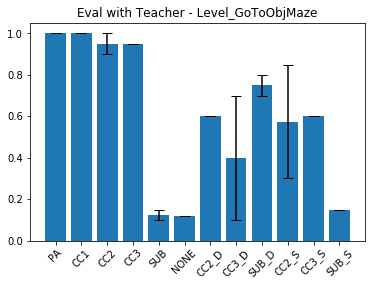

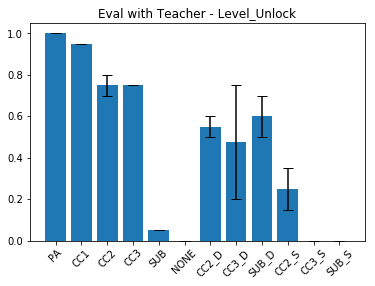

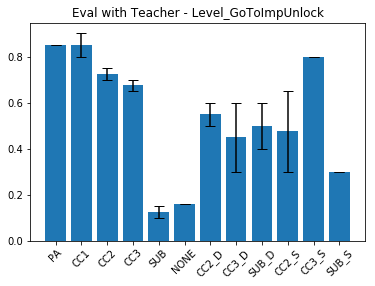

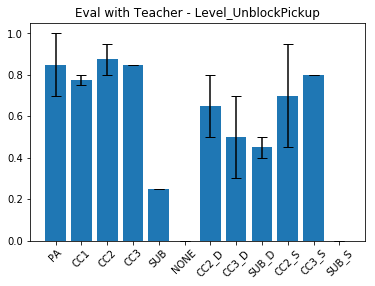

In [14]:
runs = [
    (['EVAL_539', 'EVAL_540'], 'PA'),
    (['EVAL_541', 'EVAL_542'], 'CC1'),
    (['EVAL_543', 'EVAL_544'], 'CC2'),
    (['EVAL_545', 'EVAL_546'], 'CC3'),
#     (['0722', '0723', '688'], 'SUB'),
    (['EVAL_547', 'EVAL_548'], 'SUB'),
    (['EVAL_NONE_LOWD'], 'NONE'),
    (['EVAL_557', 'EVAL_558'], 'CC2_D'),
    (['EVAL_559', 'EVAL_560'], 'CC3_D'),
    (['EVAL_561', 'EVAL_562'], 'SUB_D'),
    (['EVAL_563', 'EVAL_564'], 'CC2_S'),
    (['EVAL_565'], 'CC3_S'),
    (['EVAL_568'], 'SUB_S'),
]

plot_final_generalization(runs, 'Eval with Teacher')

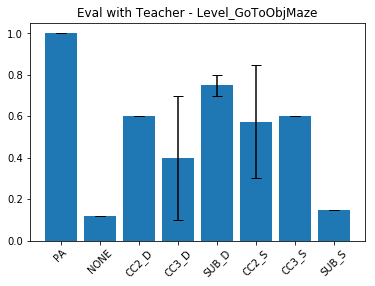

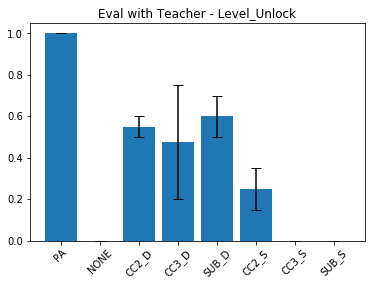

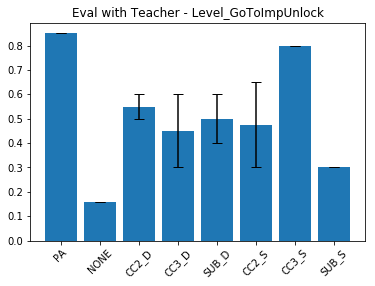

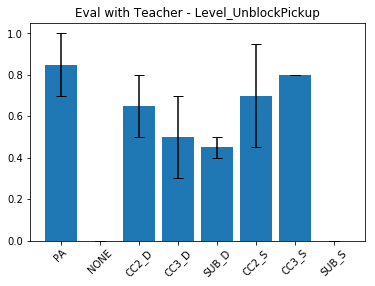

In [15]:
# WITH DISTILLATION
runs = [
    (['EVAL_539', 'EVAL_540'], 'PA'),
#     (['EVAL_541', 'EVAL_542'], 'CC1'),
#     (['EVAL_543', 'EVAL_544'], 'CC2'),
#     (['EVAL_545', 'EVAL_546'], 'CC3'),
#     (['0722', '0723', '688'], 'SUB'),
#     (['EVAL_547', 'EVAL_548'], 'SUB'),
    (['EVAL_NONE_LOWD'], 'NONE'),
    (['EVAL_557', 'EVAL_558'], 'CC2_D'),
    (['EVAL_559', 'EVAL_560'], 'CC3_D'),
    (['EVAL_561', 'EVAL_562'], 'SUB_D'),
    (['EVAL_563', 'EVAL_564'], 'CC2_S'),
    (['EVAL_565'], 'CC3_S'),
    (['EVAL_568'], 'SUB_S'),
]

plot_final_generalization(runs, 'Eval with Teacher')

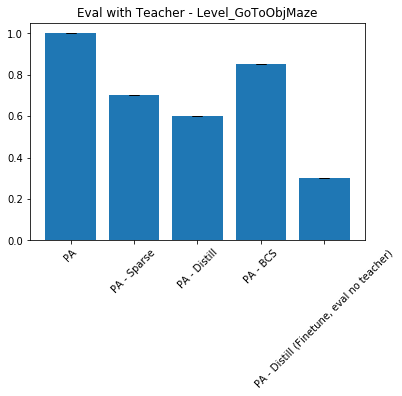

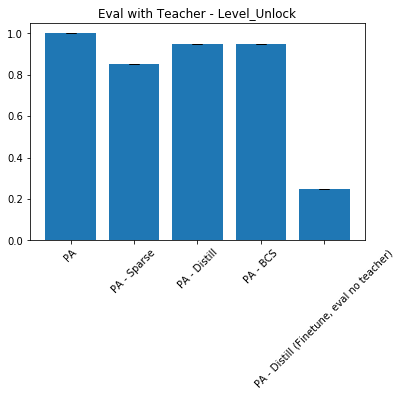

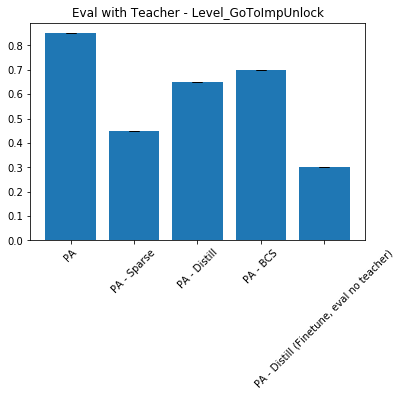

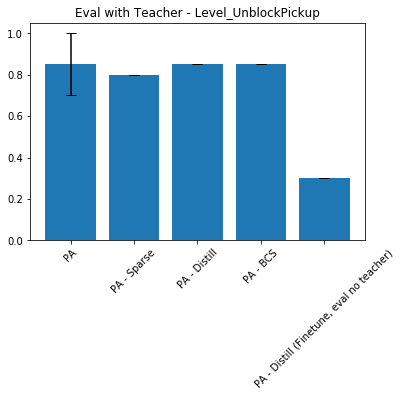

In [16]:
runs = [
    (['EVAL_539', 'EVAL_540'], 'PA'),
    (['EVAL_577'], 'PA - Sparse'),
    (['EVAL_627_NOFINETUNE'], 'PA - Distill'),
#     (['0706'], 'PA - Self-Distill'),
#     (['0677', '0678'], 'PA - No 10 Rule'),
    (['EVAL_655'], 'PA - BCS'),
    (['EVAL_627_FINETUNE'], 'PA - Distill (Finetune, eval no teacher)'),
#     (['692', '693'], 'PA - Big Batch No Distill'),
#     (['698', '699'], 'PA - Big Batch Distill'),
]
plot_final_generalization(runs, 'Eval with Teacher')

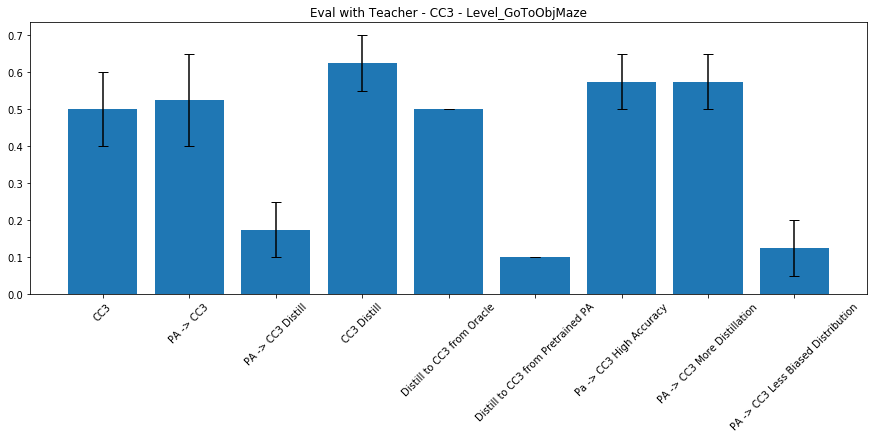

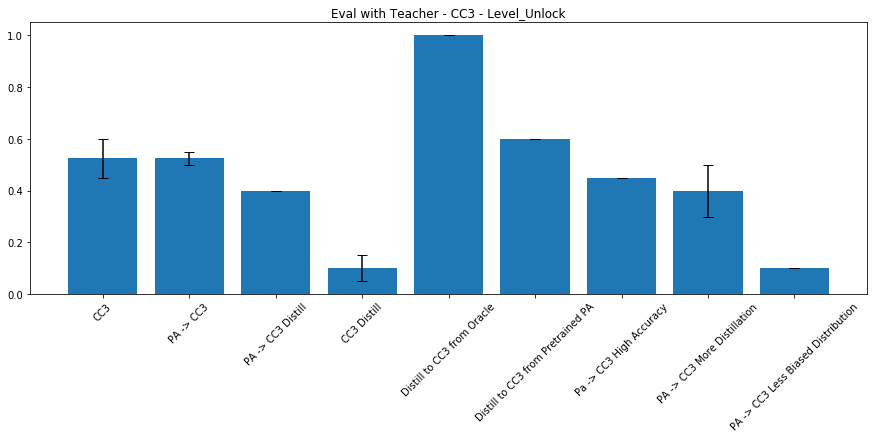

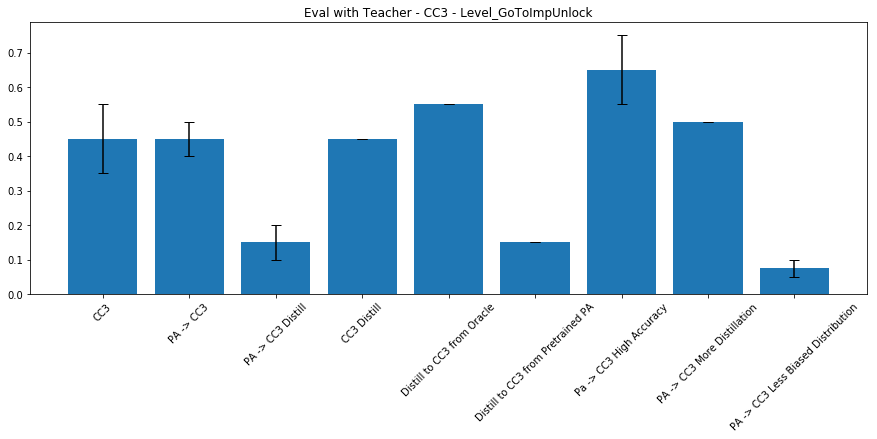

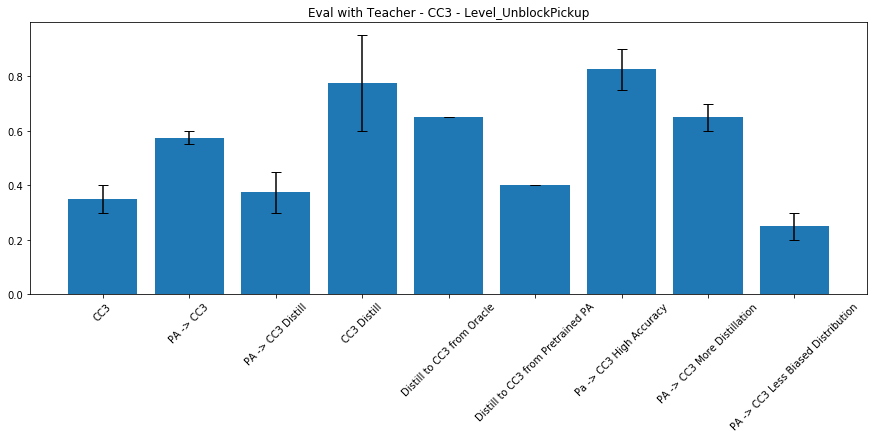

In [17]:
plt.rcParams['figure.figsize'] = [15, 5]
runs = [
    (['EVAL_885_NOFINETUNE', 'EVAL_886_NOFINETUNE'], 'CC3'),
    (['EVAL_895_NOFINETUNE', 'EVAL_896_NOFINETUNE'], 'PA -> CC3'),
    (['EVAL_821_NOFINETUNE', 'EVAL_822_NOFINETUNE'], 'PA -> CC3 Distill'),
    (['EVAL_889_NOFINETUNE', 'EVAL_890_NOFINETUNE'], 'CC3 Distill'),
    (['EVAL_659_NOFINETUNE'], 'Distill to CC3 from Oracle'),
    (['EVAL_851_NOFINETUNE'], 'Distill to CC3 from Pretrained PA'),
    (['EVAL_873_NOFINETUNE', 'EVAL_874_NOFINETUNE'], 'Pa -> CC3 High Accuracy'),
    (['EVAL_869_NOFINETUNE', 'EVAL_870_NOFINETUNE'], 'PA -> CC3 More Distillation'),
    (['EVAL_863_NOFINETUNE', 'EVAL_864_NOFINETUNE'], 'PA -> CC3 Less Biased Distribution'),
]
plot_final_generalization(runs, 'Eval with Teacher - CC3')

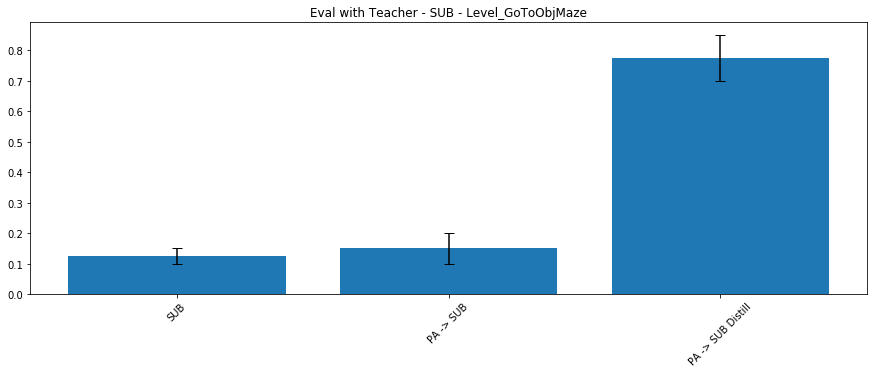

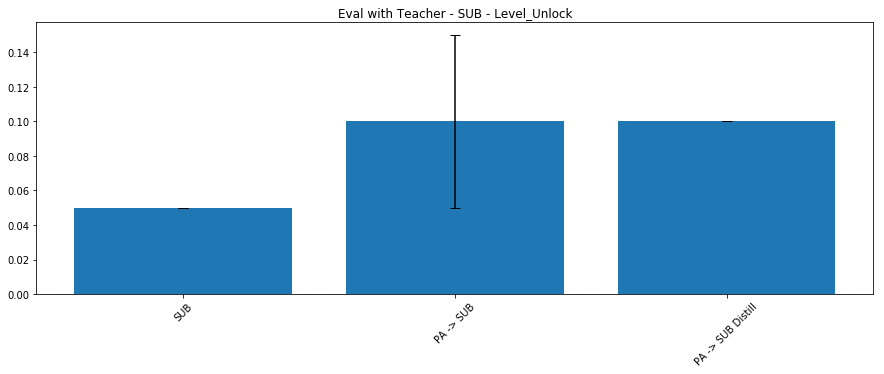

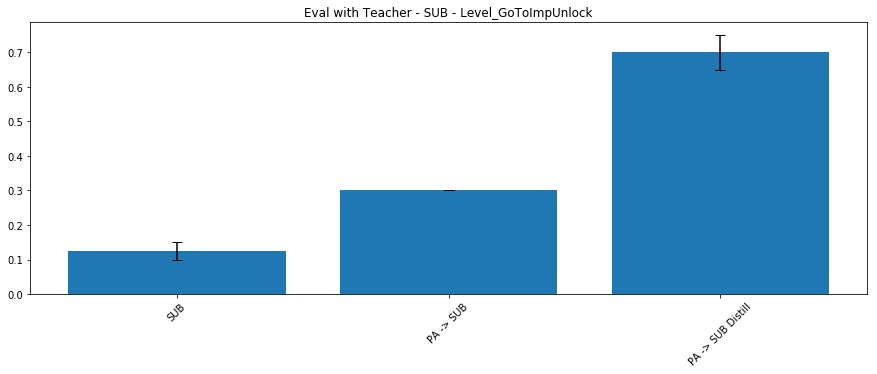

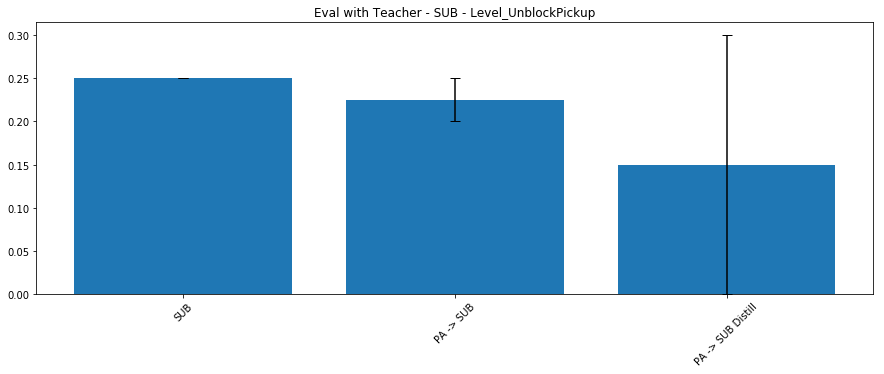

In [18]:
runs = [
    (['EVAL_547', 'EVAL_548'], 'SUB'),
    (['EVAL_635_NOFINETUNE', 'EVAL_636_NOFINETUNE'], 'PA -> SUB'),
    (['EVAL_668_NOFINETUNE', 'EVAL_669_NOFINETUNE'], 'PA -> SUB Distill'),
]
plot_final_generalization(runs, 'Eval with Teacher - SUB')

## <font color='purple'> [HELPER] Does removing instructions help generalization? (seems like not much) </font>

Conclusion: No significant difference. Even with Subgoals, where it sometimes helped, I think it's just b/c that run went longer! We could continue the existing runs to check that though.

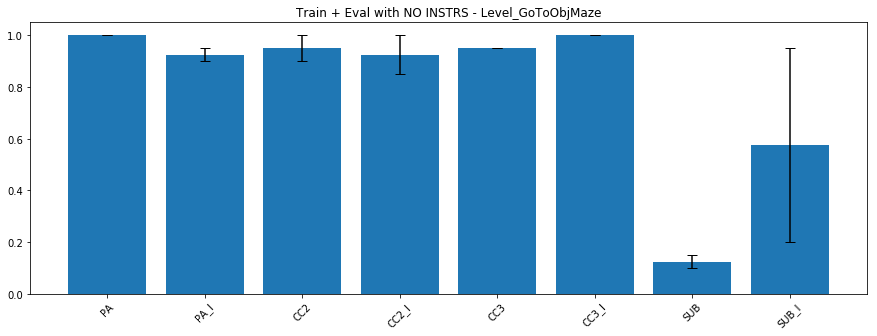

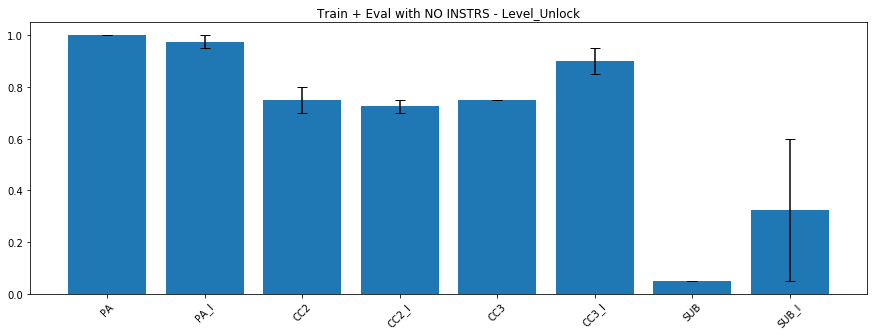

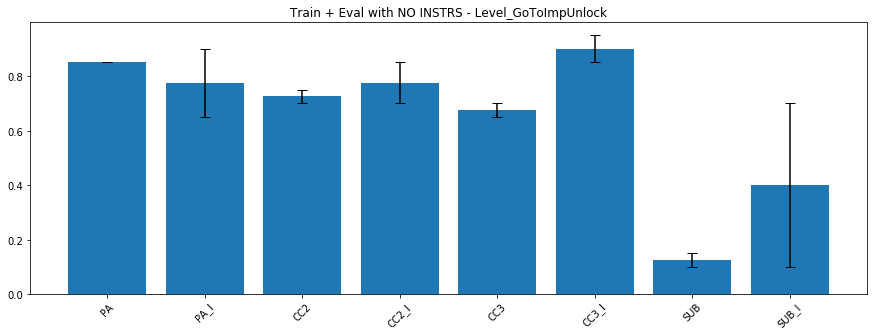

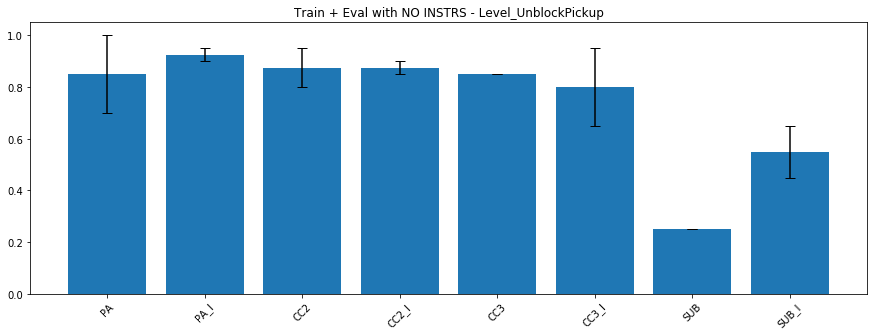

In [19]:

runs = [
    (['EVAL_539', 'EVAL_540'], 'PA'),
    (['EVAL_579', 'EVAL_580'], 'PA_I'),
    (['EVAL_543', 'EVAL_544'], 'CC2'),
    (['EVAL_581', 'EVAL_582'], 'CC2_I'),
    (['EVAL_545', 'EVAL_546'], 'CC3'),
    (['EVAL_597', 'EVAL_598'], 'CC3_I'),
    (['EVAL_547', 'EVAL_548'], 'SUB'),
    (['EVAL_599', 'EVAL_600'], 'SUB_I'),
]

plot_final_generalization(runs, 'Train + Eval with NO INSTRS')

# <font color='green'> Claim 3: Training with teacher + distilling few-shot generalizes to new levels faster. </font> <font color='red'> [TODO: code this up] </font>

## <font color='green'> [Status: Work in Progress. No results yet.] </font>

# <font color='blue'> Claim 4: Lower-level communication is more efficient to ground.</font>

## <font color='blue'> [Status: Definitely true, but no plots to show it yet.] </font>

## <font color='blue'>[STATUS] </font>

The goal is to motivate why we want to bootstrap rather than using the higher-level teachers directly.

This is true from what we've seen so far. We could probably show this in a graph by training an agent (either on the start of the curriculum or on a certain level), and checking periodically whether it can solve the held-out levels. The easy teachers should be able to do this more quickly than the harder teachers.

# <font color='purple'> Claim 5: Higher level communication is most feedback-efficient on new levels once grounded. </font>

## <font color='purple'> [Status: Hints this is true at the end of curriculm learning. We haven't yet seen it in held-out levels.] </font>


The goal is to motivate why we want higher-level teachers at all.

In theory, the generalization exps (claim 3) should show this.

# <font color='green'> Claim 6: We can ground higher-level feedback using lower-level feedback and minimal use of the reward. This is more efficient than grounding the higher-level communication directly. </font>

## <font color='green'> [Status: Self-distill > Bootstrap > Train directly] </font> <font color='red'> </font>


Goal is to show that bootstrapping is a reasonable thing to do.

May also help with grounding harder teachers better.

TODO

## <font color='green'> Comparing the Feedback Efficiency of Bootstrapping vs not (NO distillation) </font>
### (a) Train on higher-level teacher directly
### (b) Train with easy teacher, distill to higher-level teacher
### (c) Start training on easy teacher, then distill from easy to higher-level teacher, than train with higher-level teacher

In all cases, the agent advances to the next curriculum level when it can perform well on the highest-level teacher currently provided.

Error tokenizing data. C error: Expected 76 fields in line 3, saw 94



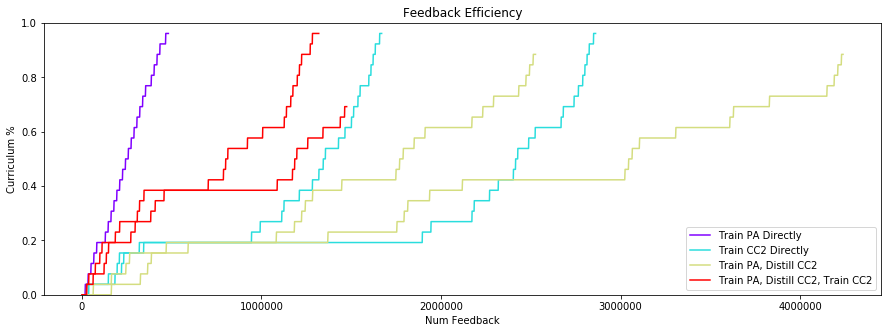

Error tokenizing data. C error: Expected 76 fields in line 3, saw 94

Error tokenizing data. C error: Expected 76 fields in line 3, saw 94



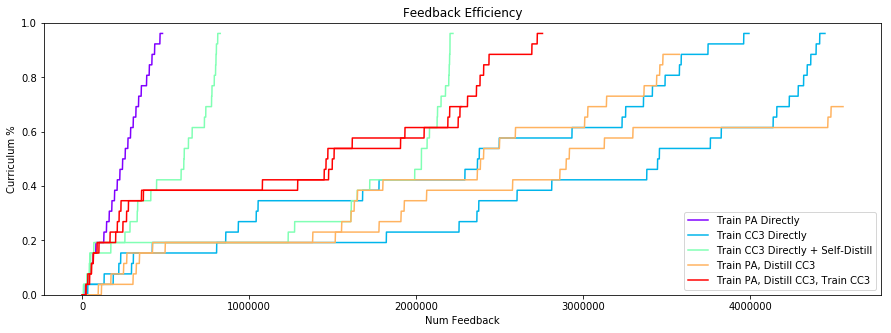

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 76 fields in line 3, saw 94

Error tokenizing data. C error: Expected 76 fields in line 3, saw 94



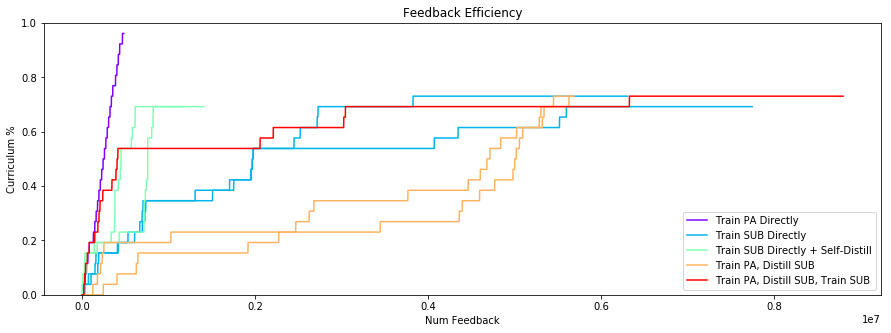

In [20]:
data_names = [
    (['0540'], 'Train PA Directly'),
#     (['0539', '0540'], 'Train PA Directly'),
    (['0543', '0544'], 'Train CC2 Directly'),
    (['0557', '0558'], 'Train PA, Distill CC2'),
    (['637', '638'], 'Train PA, Distill CC2, Train CC2'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0540'], 'Train PA Directly'),
    (['0545', '0546'], 'Train CC3 Directly'),
    (['682', '683'], 'Train CC3 Directly + Self-Distill'),
    (['0559', '0560'], 'Train PA, Distill CC3'),
    (['639', '640'], 'Train PA, Distill CC3, Train CC3'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0540'], 'Train PA Directly'),
    (['0547', '0548'], 'Train SUB Directly'),
    (['684', '685'], 'Train SUB Directly + Self-Distill'),
    (['0561', '0562'], 'Train PA, Distill SUB'),
    (['641'], 'Train PA, Distill SUB, Train SUB'),
]
plot_curriculum(data_names, 'feedback')


## <font color='green'> Comparing the Feedback Efficiency of Bootstrapping vs not (YES distillation) </font>

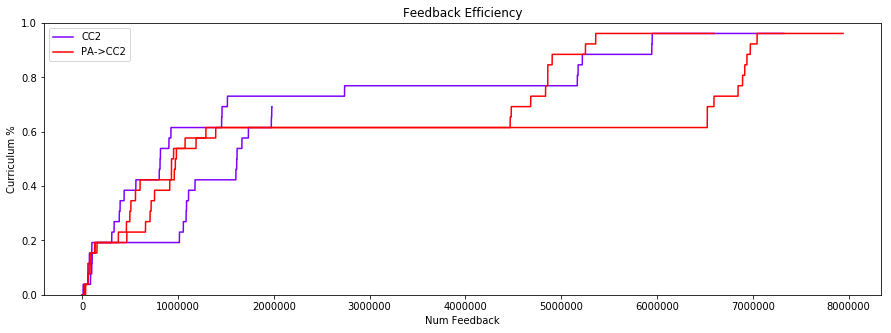

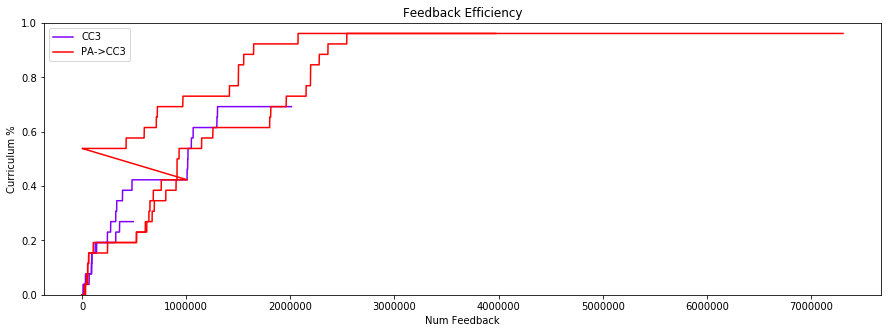

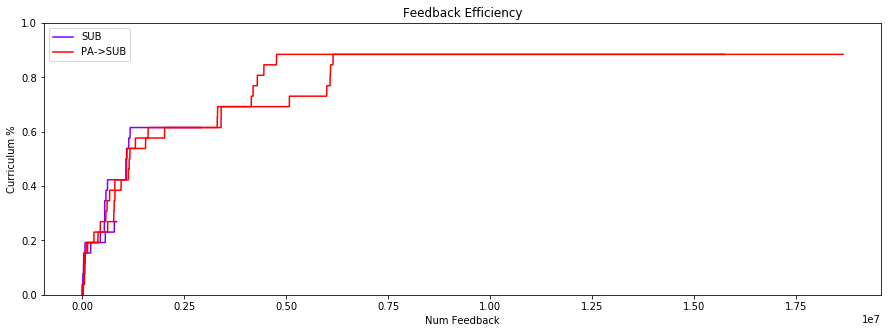

In [21]:
data_names = [
    (['0631', '0632'], 'CC2'),
    (['T0729_PRE_to_CC2', '728'], 'PA->CC2'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0633', '0634'], 'CC3'),
    (['0666', '0667'], 'PA->CC3'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0635', '0636'], 'SUB'),
    (['0668', '0669'], 'PA->SUB'),
]
plot_curriculum(data_names, 'feedback')

# <font color='blue'> Claim 8: we can (largely) remove the reward during training once the first teacher is grounded.  </font> 

## <font color='blue'> [Status: Early results show it helps for PA, not SUB].  </font> 

Let's test this by taking PA (the easiest teacher to learn) and seeing at what point during training it can zero-shot solve the entire curriculum.

## <font color='blue'> [Helper] See how early through the curriculum we can remove the reward. </font>

Currently suggests there's no one point where the reward can be removed; we need to keep checking it it and training if needed.

LEVELS ['T0627_CURRICULUM1_PRE_teacherPreActionAdvice_SAME_SD_dense_threshS0.99_threshA0.6_lr0.0001_ent0']


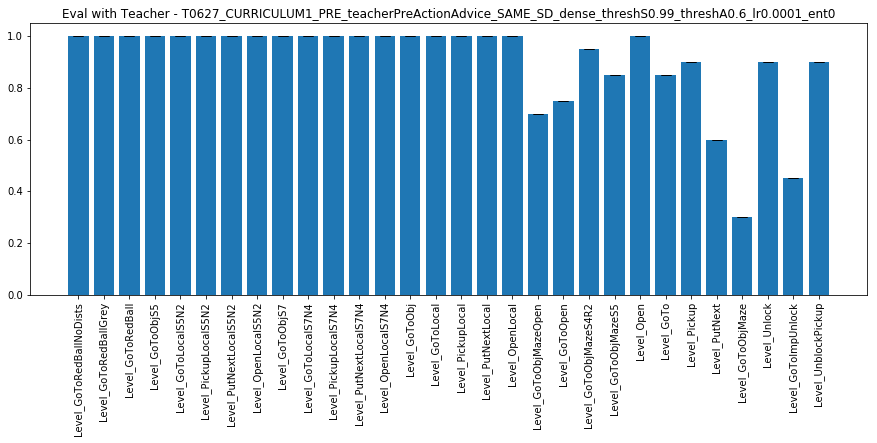

In [22]:
runs = [
    (['EVAL_ALL_LEVELS_627'], 'PA'),
]
plot_curriculum_generalization(runs, 'Eval with Teacher')

LEVELS ['latest']


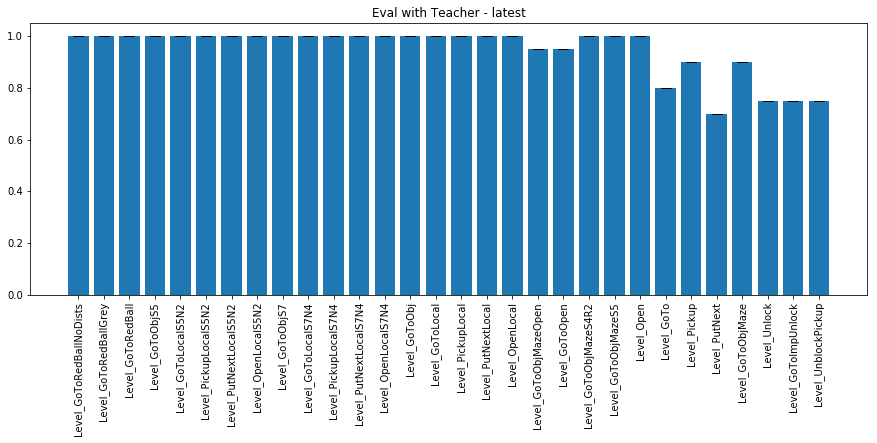

LEVELS ['level_12', 'level_17', 'level_7']


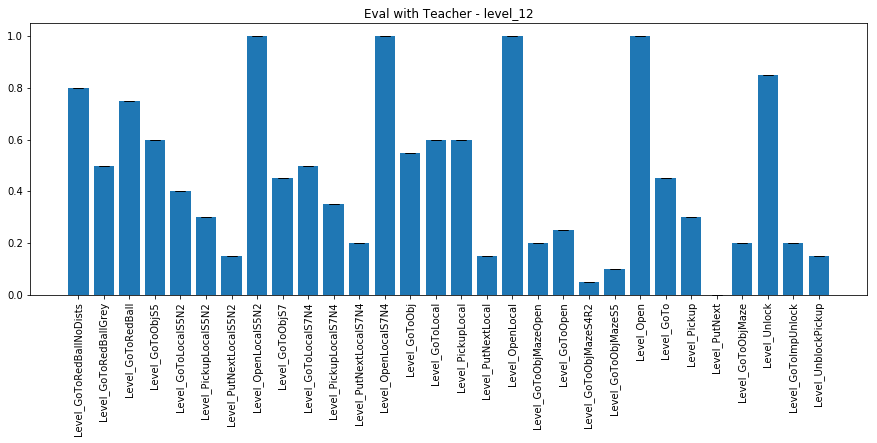

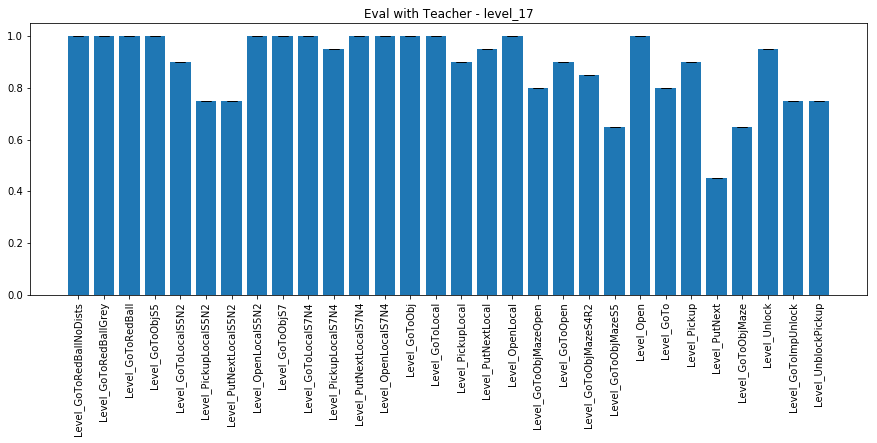

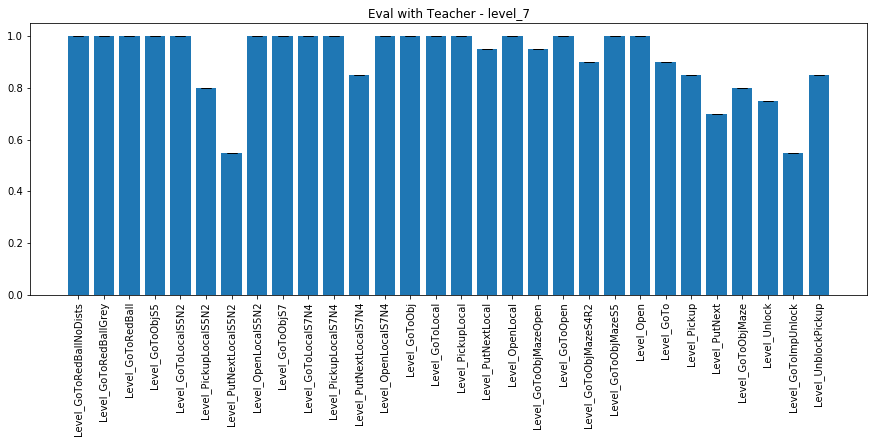

In [23]:
runs = [
    (['EVAL_PA_EARLY_FINAL_455'], 'PA'),
    (['EVAL_PA_EARLY_455_mid'], 'PA'),
]
plot_curriculum_generalization(runs, 'Eval with Teacher')

## <font color='blue'> [Helper] See if we can zero-shot some levels. </font>

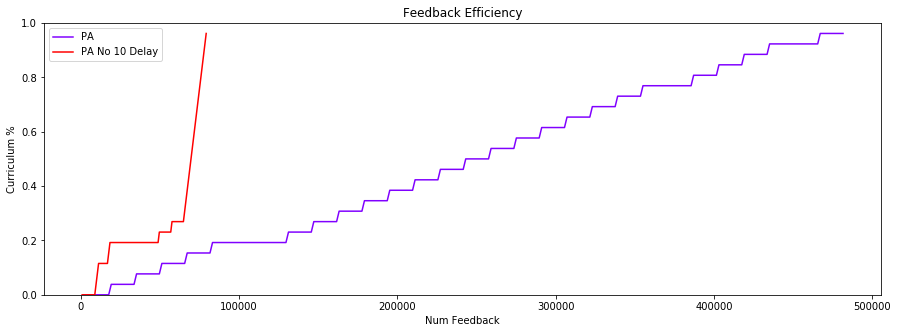

In [24]:
data_names = [
    (['0540'], 'PA'),
    (['676'], 'PA No 10 Delay'),
#     (['677', '678'], "PA Don't train each level"),  # TODO: This one doesn't actually skip training on some levels
]
plot_curriculum(data_names, 'feedback')

## <font color='blue'> [Main] Remove reward during training when possible </font>

Tries reward periodically. If the agent succeeds, we skip training for the next few itrs.

NOTE: Would probably make more sense to separate sparse vs per-timestep rewards. Only provide per-timestep rewards if the agent is failing at getting the sparse rewards.

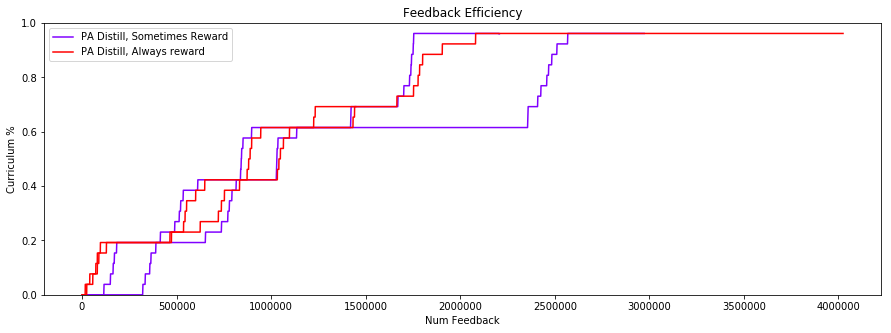

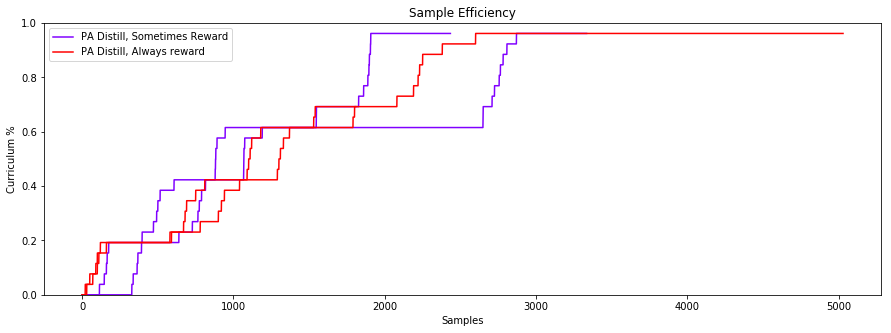

In [25]:
data_names = [
    (['0729_PA', '0730'], 'PA Distill, Sometimes Reward'),
    (['0627', '0628'], 'PA Distill, Always reward'),
]
plot_curriculum(data_names, 'feedback')
plot_curriculum(data_names, 'samples')

Found multiple files with name 668: ['T0668_PRE_to_SUB_teacherPreActionAdvice, SubgoalCorrections_SAME_SD_dense_threshS0.99_threshA0.6_lr0.0001_ent0.001_currfnone_hot_1', 'EVAL_668_NOFINETUNE']
couldn't plot PA -> Sub Distill, Always reward


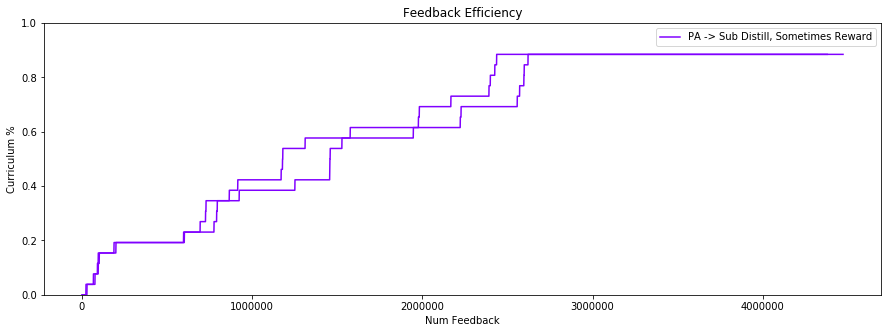

Found multiple files with name 668: ['T0668_PRE_to_SUB_teacherPreActionAdvice, SubgoalCorrections_SAME_SD_dense_threshS0.99_threshA0.6_lr0.0001_ent0.001_currfnone_hot_1', 'EVAL_668_NOFINETUNE']
couldn't plot PA -> Sub Distill, Always reward


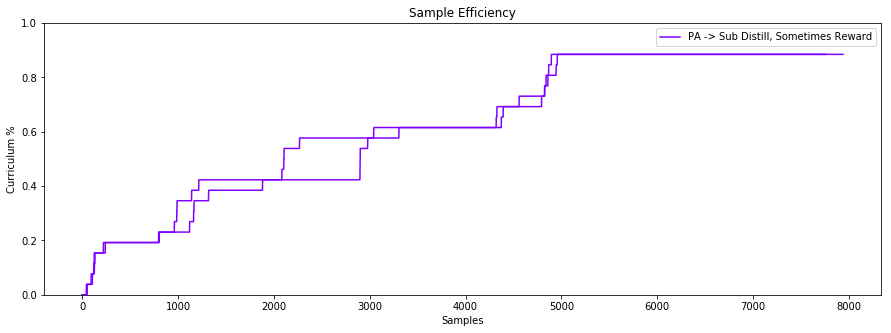

In [26]:
data_names = [
    (['735', '736'], 'PA -> Sub Distill, Sometimes Reward'),
    (['668', '669'], 'PA -> Sub Distill, Always reward'),
]
plot_curriculum(data_names, 'feedback')
plot_curriculum(data_names, 'samples')

# <font color='purple'> Leaderboard - Curriculum Learning  </font>

Keep track of the current best methods of learning a curriculum (ranked by feedback-efficiency).

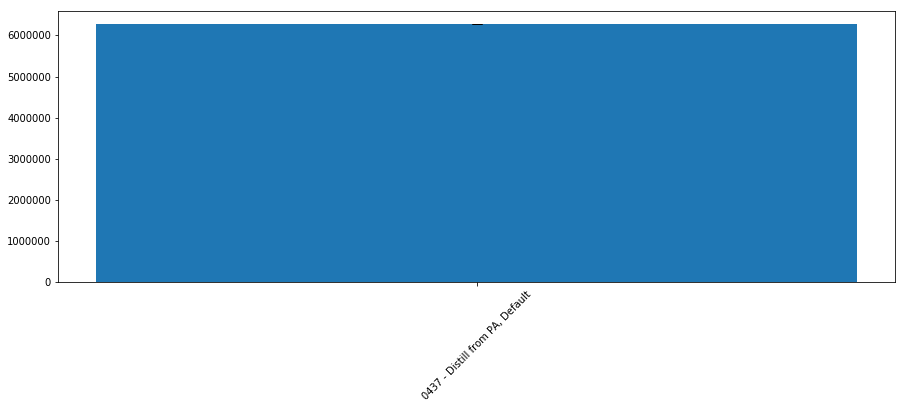

In [27]:
methods = [
    (['0437'], "Distill from PA, Default", "Standard HParams, train PA, distill to powerset"), # TODO: placeholder; hasn't actually succeeded yet
]

plot_leaderboard(methods)


# <font color='green'> Leaderboard - Curriculum Learning (no distillation)  </font>

Keep track of the current best methods of learning a curriculum (ranked by feedback-efficiency).

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77



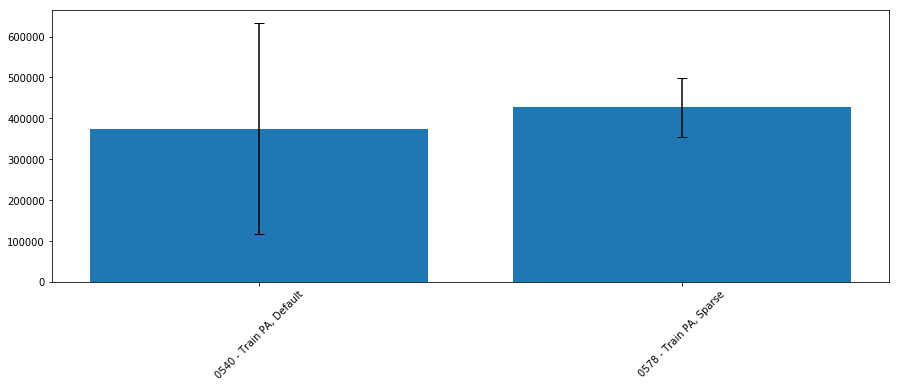

In [28]:
methods = [
    (['0539', '0540'], "Train PA, Default", "Standard HParams, train PA"),
    (['0577', '0578'], "Train PA, Sparse", "Standard HParams, train PA"),
]

plot_leaderboard(methods)


# <font color='blue'> Leaderboard - Few-Shot Generalization </font>


Keep track of the current best methods of few-shot learning heldout levels (ranked by feedback-efficiency).

TODO

# <font color='purple'> Miscellaneous Other Plots </font> <font color='red'> [TODO: plot sweeps] </font>

## <font color='purple'> Does bigger batch size help? </font>

Conclusion: It helps when subgoals not distilling, but doesn't help when distilling. We should check whether this holds for other teachers.

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77



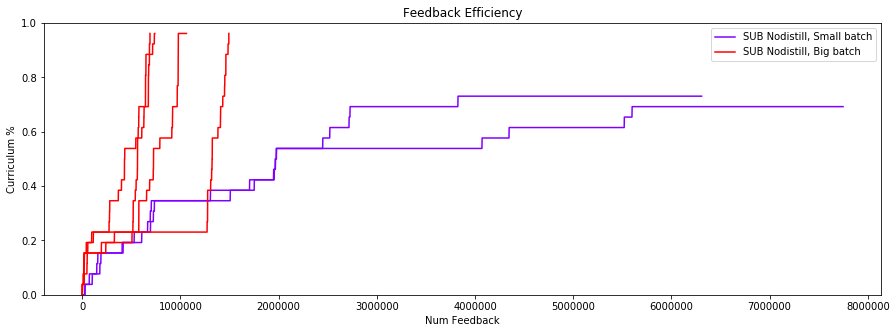

Found multiple files with name 636: ['T0636_CURRICULUM1_SUB_teacherSubgoalCorrections_SAME_SD_dense_threshS0.99_threshA0.6_lr0.0001_ent0.0001_currfnone_hot_2', 'EVAL_636_NOFINETUNE']
couldn't plot SUB Distill, Small batch


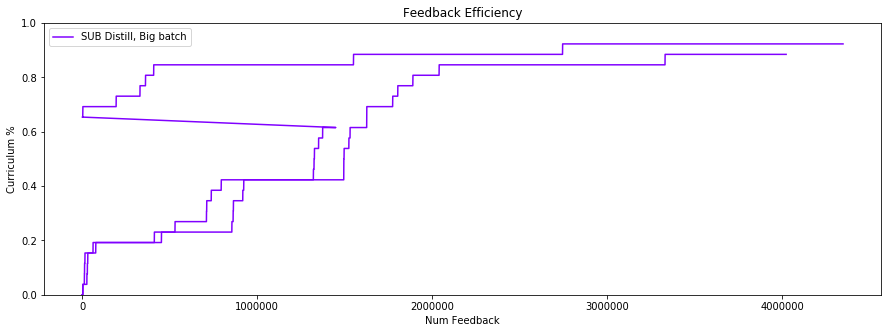

Found multiple files with name 668: ['T0668_PRE_to_SUB_teacherPreActionAdvice, SubgoalCorrections_SAME_SD_dense_threshS0.99_threshA0.6_lr0.0001_ent0.001_currfnone_hot_1', 'EVAL_668_NOFINETUNE']
couldn't plot PA->SUB Distill, Small batch


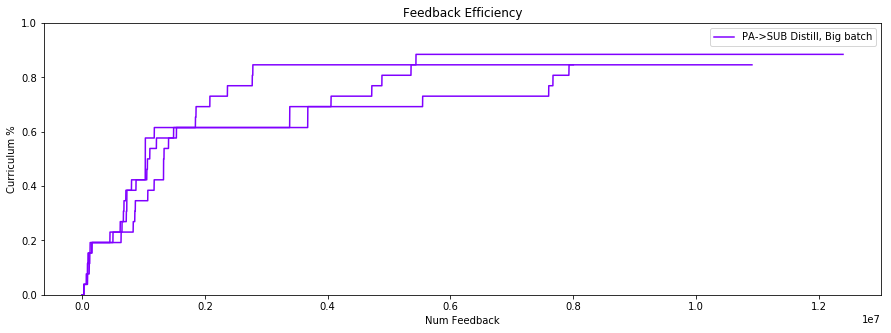

In [29]:
data_names = [
    (['0547', '0548'], 'SUB Nodistill, Small batch'),
    (['0722', '0723', '688'], 'SUB Nodistill, Big batch'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['718', '719', '636', '0635'], 'SUB Distill, Small batch'),
    (['690'], 'SUB Distill, Big batch'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['720', '721', '668', '669'], 'PA->SUB Distill, Small batch'),
    (['726', '725', '724'], 'PA->SUB Distill, Big batch'),
]
plot_curriculum(data_names, 'feedback')



### No distillation

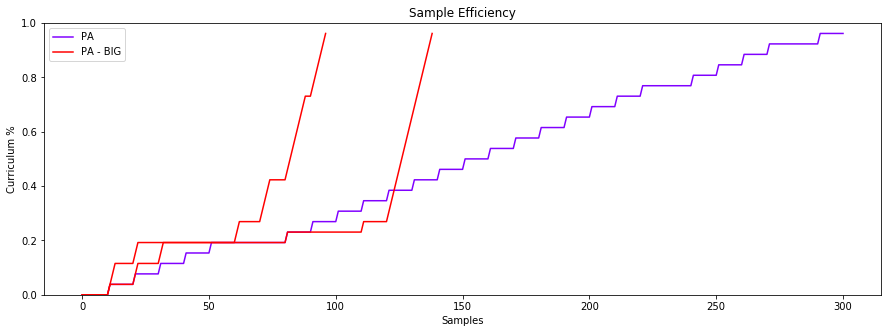

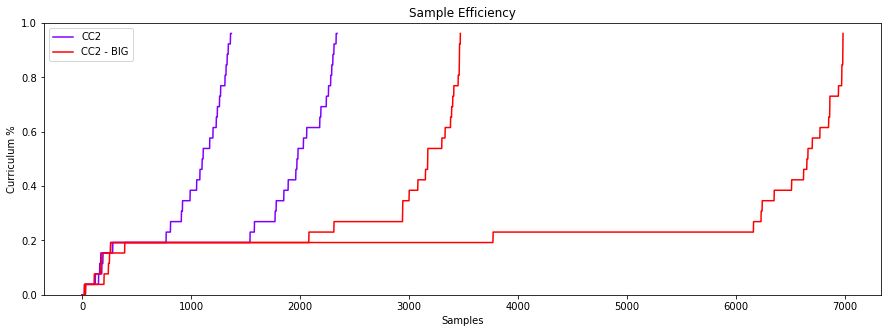

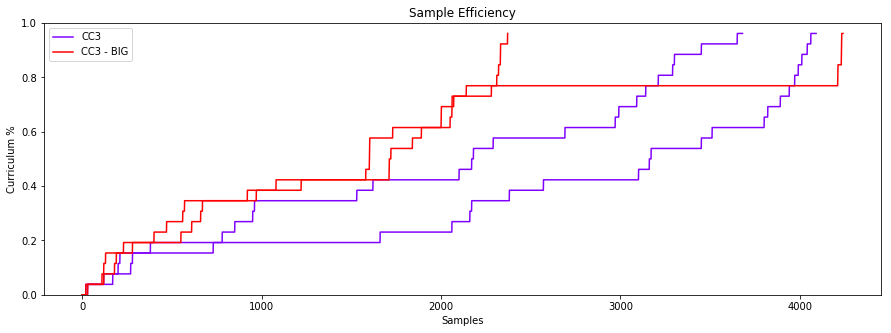

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

Error tokenizing data. C error: Expected 65 fields in line 3, saw 77



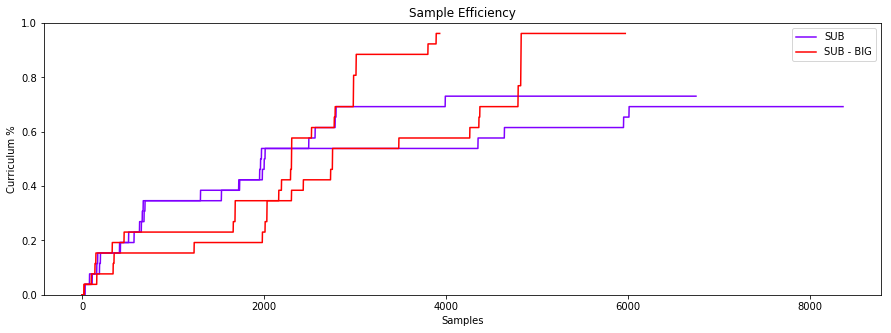

In [30]:
# NO DISTILLATION

data_names = [
    (['0540'], 'PA'),
    (['692', '693'], 'PA - BIG'),
]
plot_curriculum(data_names, 'samples')  # WORSE

data_names = [
    (['0543', '0544'], 'CC2'),
    (['694', '695'], 'CC2 - BIG'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0545', '0546'], 'CC3'),
    (['696', '697'], 'CC3 - BIG'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0547', '0548'], 'SUB'),
    (['688'], 'SUB - BIG'),
]
plot_curriculum(data_names, 'samples')


### Distillation

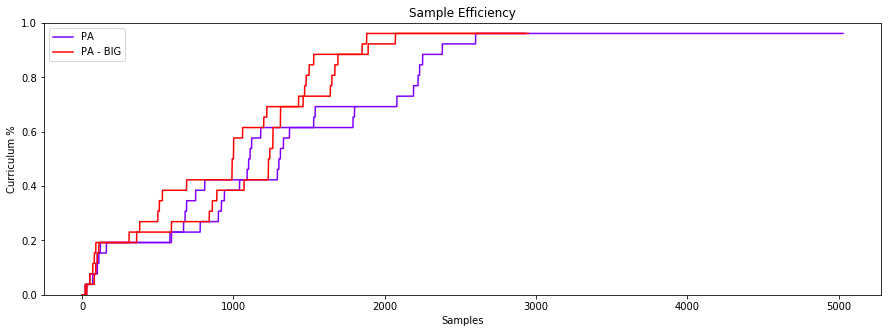

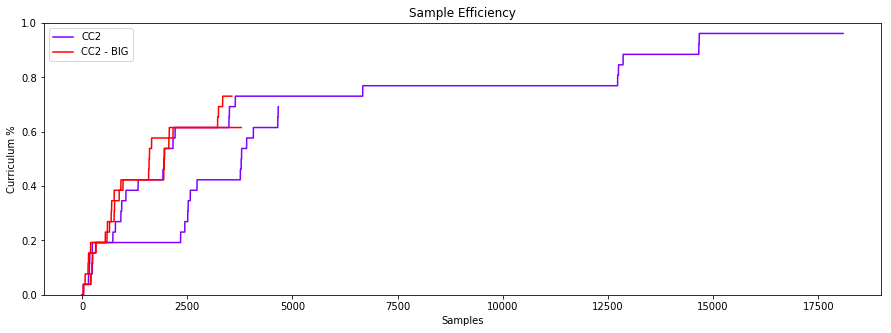

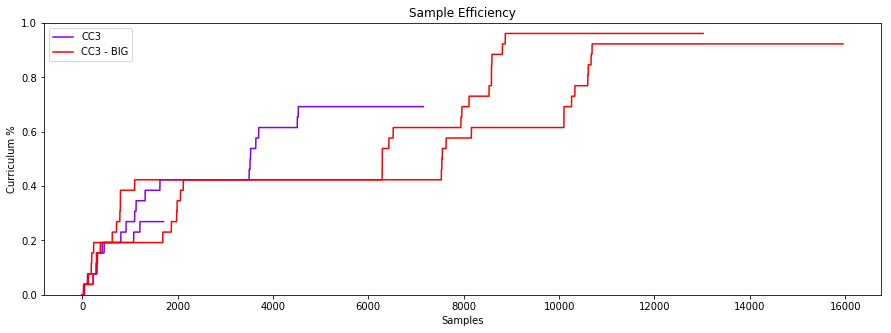

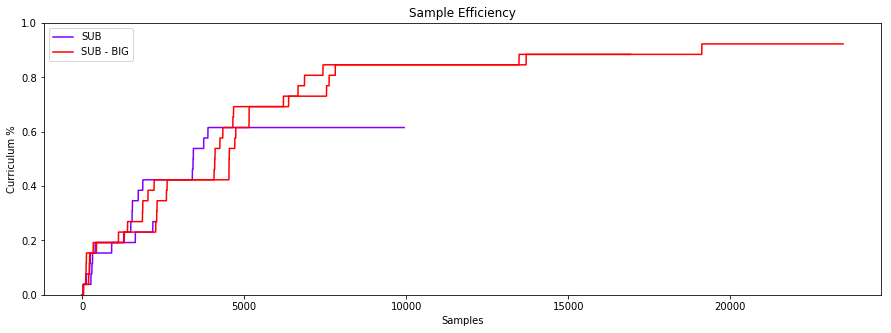

In [31]:
data_names = [  # TODO: re-run these 
    (['0627', '0628'], 'PA'),
    (['698', '699'], 'PA - BIG')
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0631', '0632'], 'CC2'),
    (['700', '701'], 'CC2 - BIG'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0633', '0634'], 'CC3'),
    (['702', '703'], 'CC3 - BIG')
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0635', '0636'], 'SUB'),
    (['690'], 'SUB - BIG')
]
plot_curriculum(data_names, 'samples')

## <font color='purple'> Does a bigger model help? </font>

Helps a little bit...

Found multiple files with name 636: ['T0636_CURRICULUM1_SUB_teacherSubgoalCorrections_SAME_SD_dense_threshS0.99_threshA0.6_lr0.0001_ent0.0001_currfnone_hot_2', 'EVAL_636_NOFINETUNE']
couldn't plot SUB Distill, Small model


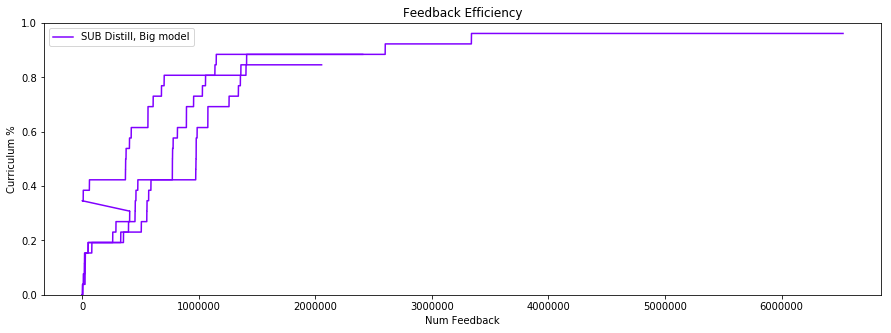

Found multiple files with name 668: ['T0668_PRE_to_SUB_teacherPreActionAdvice, SubgoalCorrections_SAME_SD_dense_threshS0.99_threshA0.6_lr0.0001_ent0.001_currfnone_hot_1', 'EVAL_668_NOFINETUNE']
couldn't plot PA->SUB Distill, Small model


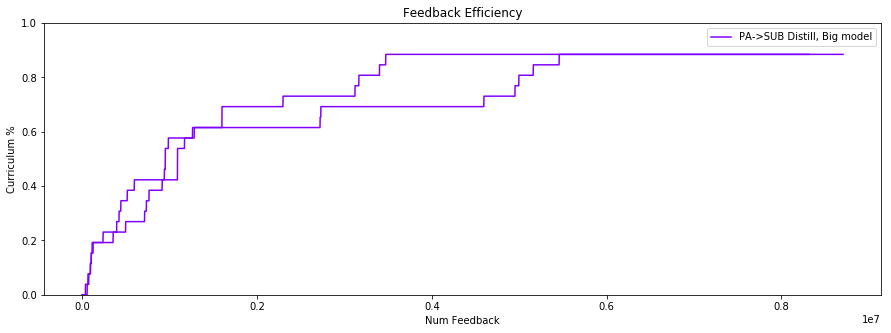

In [32]:
# data_names = [
#     (['0547', '0548'], 'SUB Nodistill, Small model'),
#     (['0722', '0723', '688'], 'SUB Nodistill, Big model'),
# ]
# plot_curriculum(data_names, 'feedback')

data_names = [
    (['718', '719', '636', '0635'], 'SUB Distill, Small model'),
    (['714', '715', '664'], 'SUB Distill, Big model'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['720', '721', '668', '669'], 'PA->SUB Distill, Small model'),
    (['716', '717'], 'PA->SUB Distill, Big model'),
]
plot_curriculum(data_names, 'feedback')


## <font color='purple'> Does self-distillation help? </font>

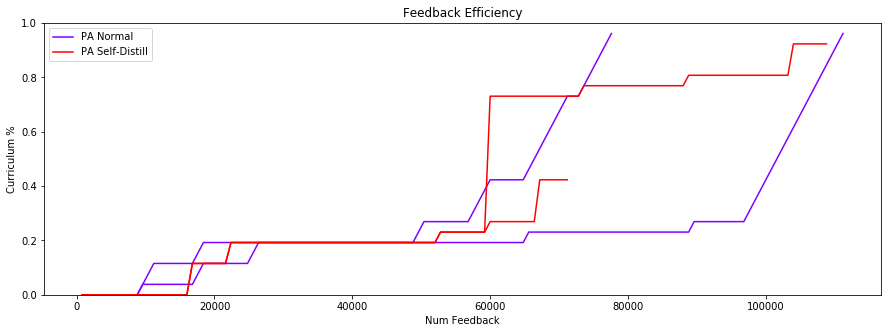

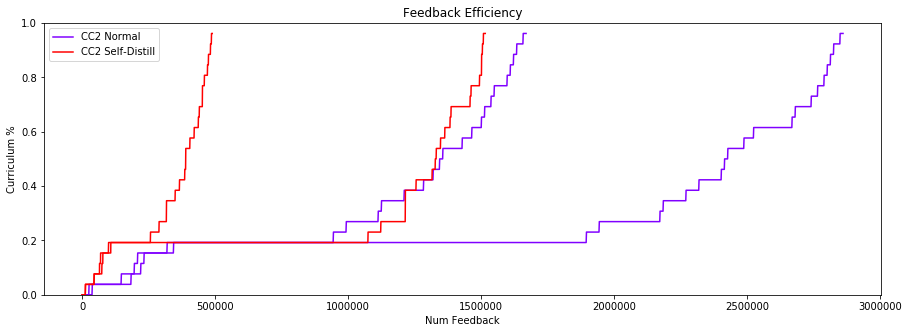

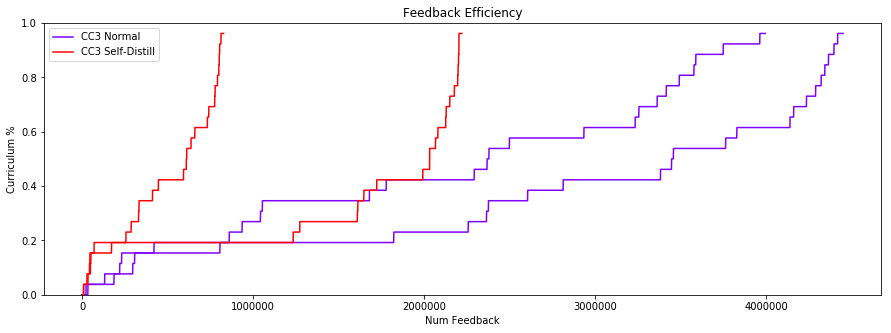

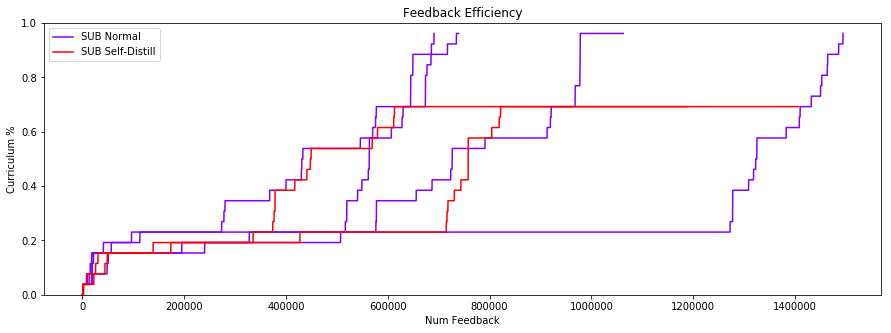

In [33]:
data_names = [
    (['692', '693'], 'PA Normal'),
    (['0706', '0707'], 'PA Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0543', '0544'], 'CC2 Normal'),
    (['0704', '0705'], 'CC2 Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0545', '0546'], 'CC3 Normal'),
    (['682', '683'], 'CC3 Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0722', '0723', '688'], 'SUB Normal'),
    (['684', '685'], 'SUB Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

## <font color='purple'> Does buffer size help?  </font>

## <font color='purple'> Does raising the RL accuracy threshold size help?  </font>

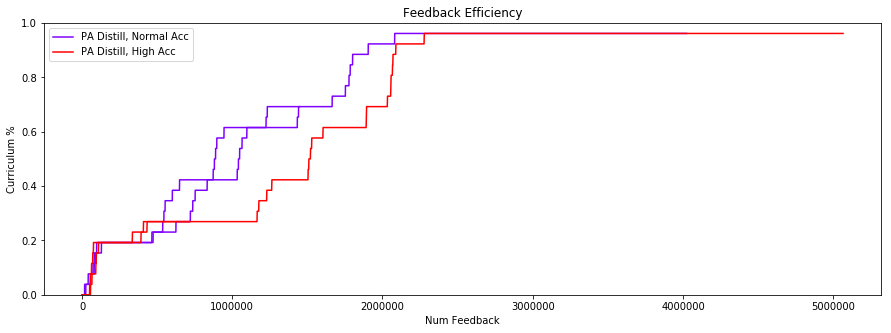

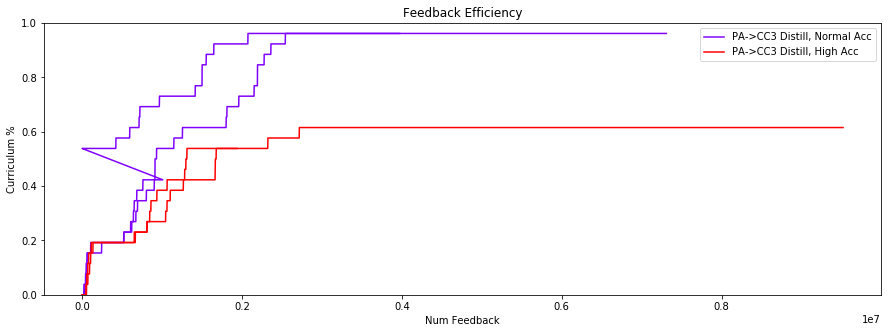

Found multiple files with name 668: ['T0668_PRE_to_SUB_teacherPreActionAdvice, SubgoalCorrections_SAME_SD_dense_threshS0.99_threshA0.6_lr0.0001_ent0.001_currfnone_hot_1', 'EVAL_668_NOFINETUNE']
couldn't plot PA->SUB, Normal Acc


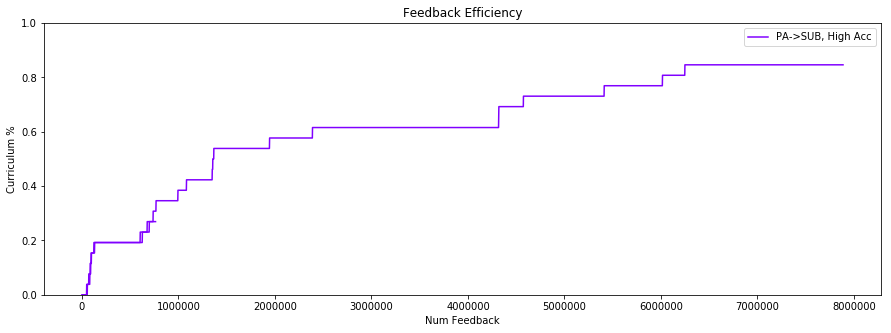

In [34]:
data_names = [
    (['0627', '0628'], 'PA Distill, Normal Acc'),
    (['0737', '0738'], 'PA Distill, High Acc'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0666', '0667'], 'PA->CC3 Distill, Normal Acc'),
    (['0739', '0740'], 'PA->CC3 Distill, High Acc'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['720', '721', '668', '669'], 'PA->SUB, Normal Acc'),
    (['0741', '0742'], 'PA->SUB, High Acc'),
]
plot_curriculum(data_names, 'feedback')


## <font color='purple'> Does lowering the discount help?  </font>

Found multiple files with name 668: ['T0668_PRE_to_SUB_teacherPreActionAdvice, SubgoalCorrections_SAME_SD_dense_threshS0.99_threshA0.6_lr0.0001_ent0.001_currfnone_hot_1', 'EVAL_668_NOFINETUNE']
couldn't plot PA->SUB, Normal Discount


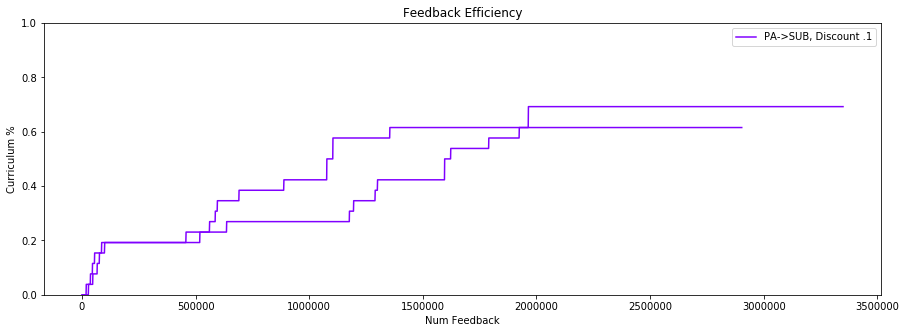

In [35]:
data_names = [
    (['720', '721', '668', '669'], 'PA->SUB, Normal Discount'),
    (['743', '744'], 'PA->SUB, Discount .1'),
]
plot_curriculum(data_names, 'feedback')

## <font color='purple'> Does the way we collect labels matter?  </font>

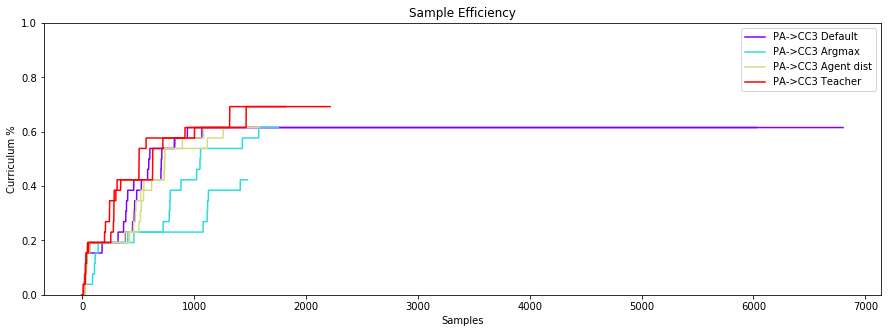

In [36]:
data_names = [
    (['0821', '0822'], 'PA->CC3 Default'),
#     (['0825', '0826'], 'PA->CC3 Big Batch'),
    (['833', '834'], 'PA->CC3 Argmax'),
    (['835', '836'], 'PA->CC3 Agent dist'),
    (['837', '838'], 'PA->CC3 Teacher'),
]
plot_curriculum(data_names, 'samples')

## <font color='purple'> Does DAgger help?  </font>

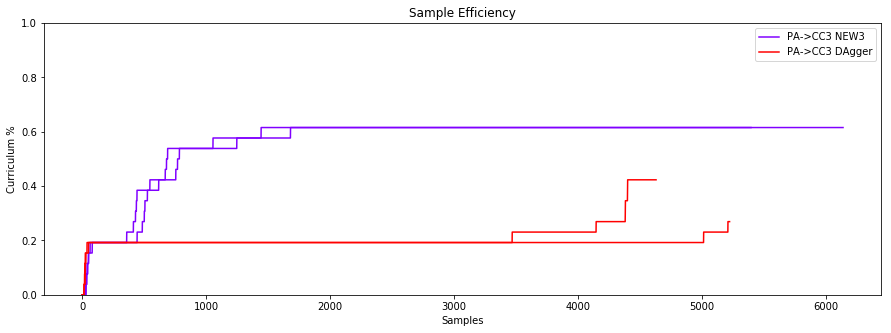

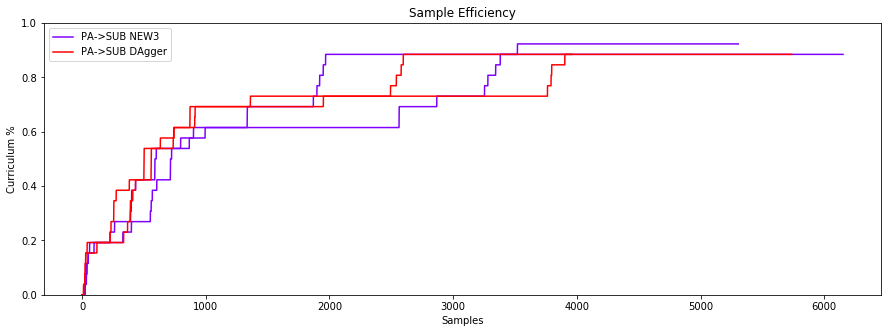

In [37]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0825', '0826'], 'PA->CC3 NEW3'),
    (['084_', '842'], 'PA->CC3 DAgger'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['827', '828'], 'PA->SUB NEW3'),
    (['843', '844'], 'PA->SUB DAgger'), #844
]
plot_curriculum(data_names, 'samples')


## <font color='purple'> Does using a separate model help?  </font>

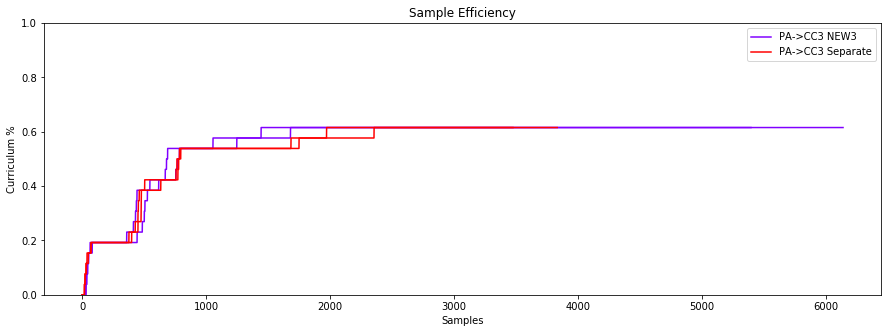

In [38]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0825', '0826'], 'PA->CC3 NEW3'),
    (['839', '840'], 'PA->CC3 Separate'),
]
plot_curriculum(data_names, 'samples')


## <font color='purple'> Does re-weighting help?  </font>

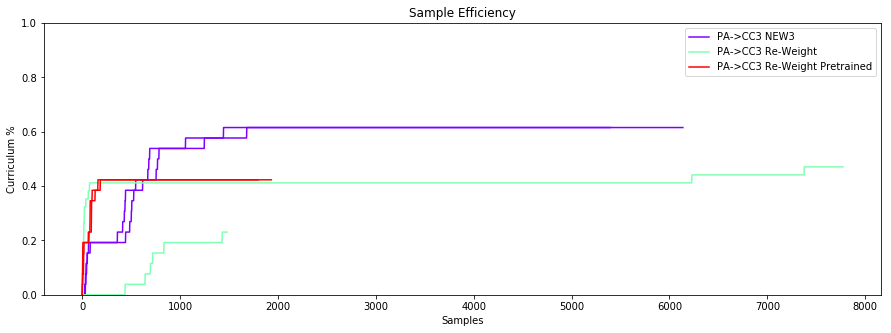

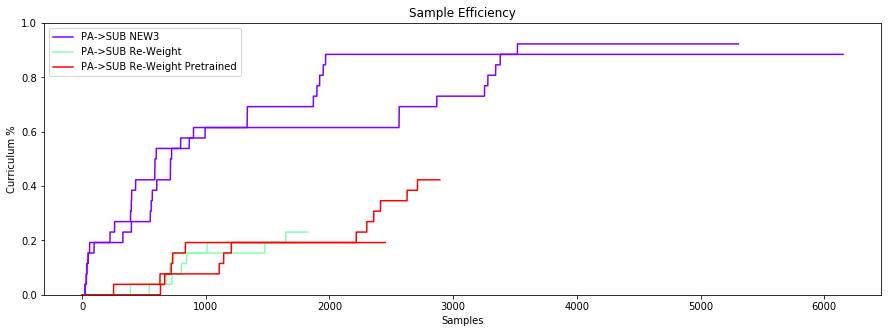

In [39]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0825', '0826'], 'PA->CC3 NEW3'),
    (['817', '180'], 'PA->CC3 Re-Weight'),
    (['813', '814'], 'PA->CC3 Re-Weight Pretrained'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['827', '828'], 'PA->SUB NEW3'),
    (['819', '820'], 'PA->SUB Re-Weight'),
    (['815', '816'], 'PA->SUB Re-Weight Pretrained'),
]
plot_curriculum(data_names, 'samples')


## <font color='purple'> Hyperparameter tuning (included dropout and pretrained)  </font>

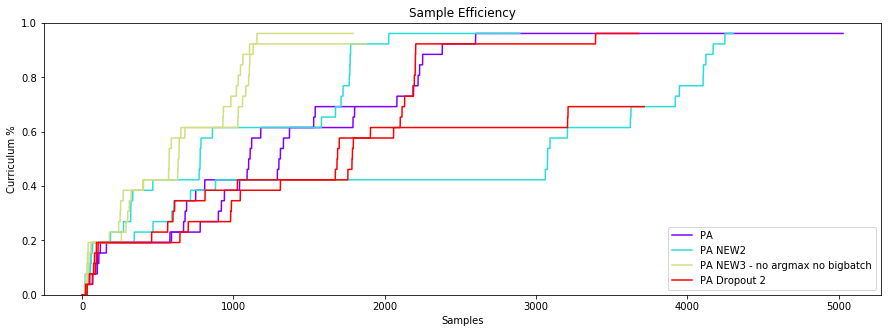

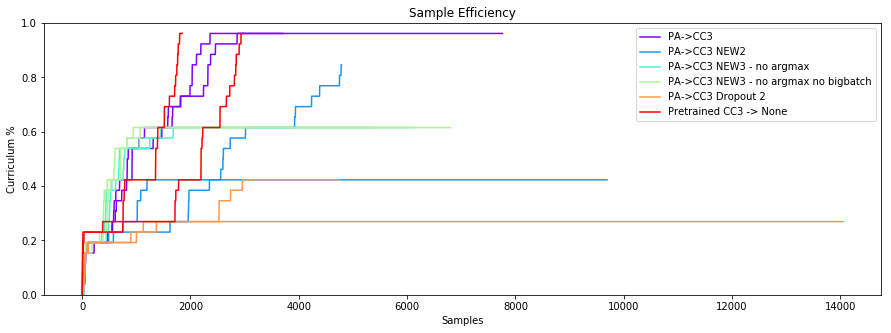

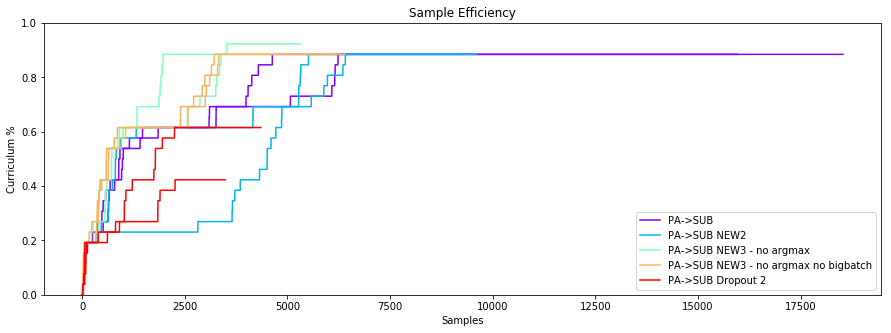

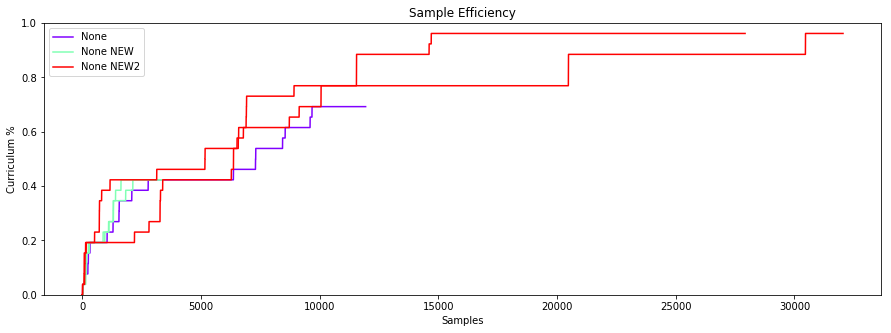

In [40]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0627', '0628'], 'PA'),
#     (['0753', '0754'], 'PA NEW'),
    (['0787', '0788'], 'PA NEW2'),
    (['867', '868'], 'PA NEW3 - no argmax no bigbatch'),
    (['801', '802'], 'PA Dropout 2'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0666', '0667'], 'PA->CC3'),
#     (['0755', '0756'], 'PA->CC3 NEW'),
    (['0789', '0790'], 'PA->CC3 NEW2'),
    (['0825', '0826'], 'PA->CC3 NEW3 - no argmax'),
    (['0821', '0822'], 'PA->CC3 NEW3 - no argmax no bigbatch'),
    (['803', '804'], 'PA->CC3 Dropout 2'),
    (['859', '860'], 'Pretrained CC3 -> None'),
]
plot_curriculum(data_names, 'samples')
data_names = [
    (['0668', '0669'], 'PA->SUB'),
#     (['0757', '0758'], 'PA->SUB NEW'),
    (['0791', '0792'], 'PA->SUB NEW2'),
    (['827', '828'], 'PA->SUB NEW3 - no argmax'),
    (['0823', '0824'], 'PA->SUB NEW3 - no argmax no bigbatch'),
    (['805', '806'], 'PA->SUB Dropout 2'),
]
plot_curriculum(data_names, 'samples')
data_names = [
    (['0481'], 'None'),
    (['0751', '0752'], 'None NEW'),
    (['0785', '0786'], 'None NEW2'),
]
plot_curriculum(data_names, 'samples')




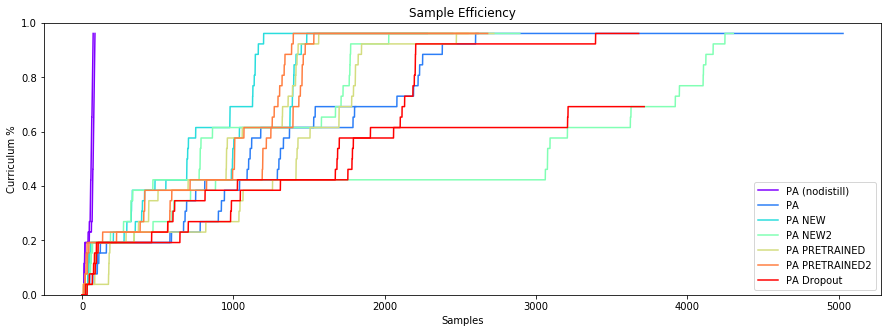

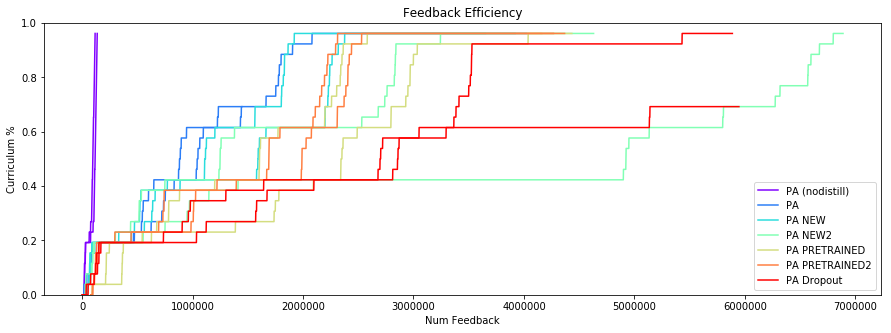

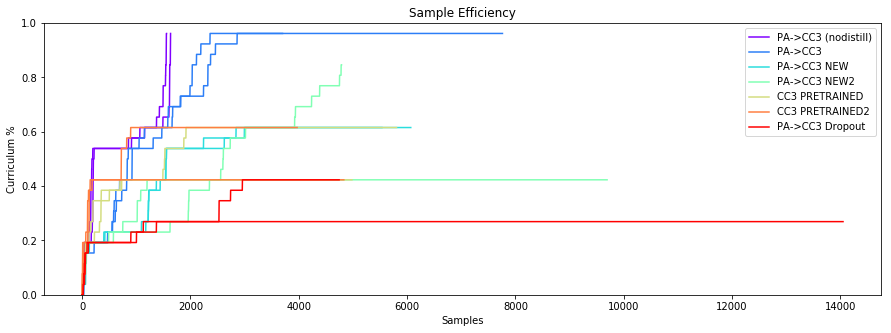

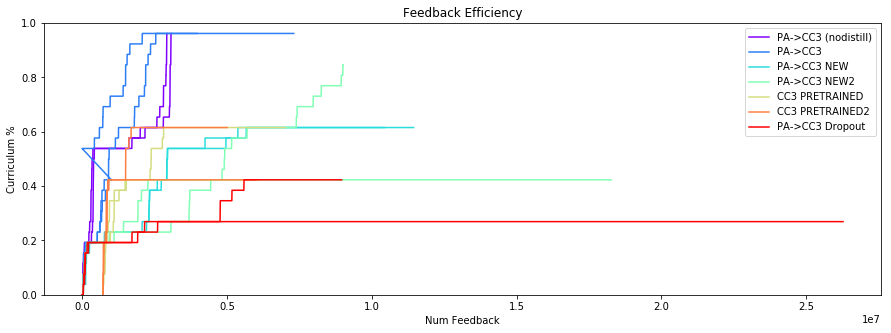

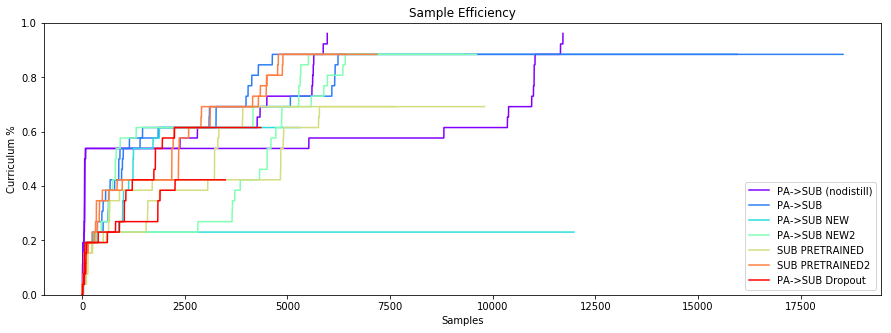

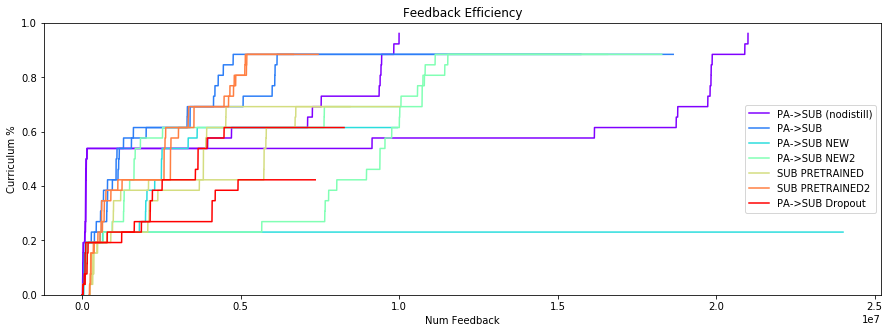

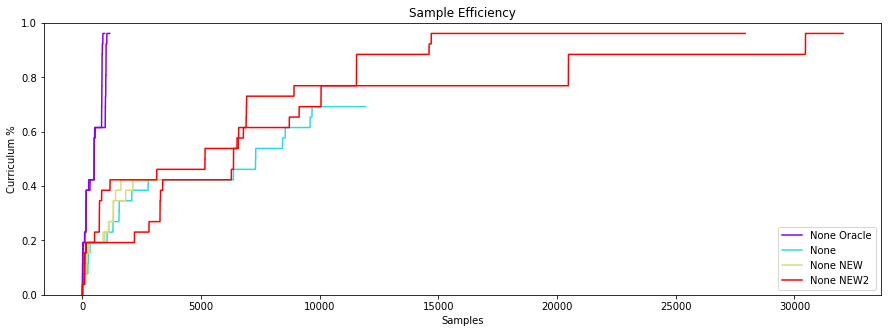

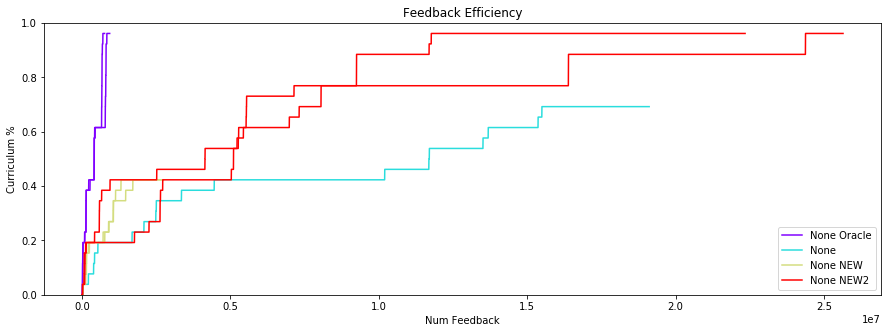

In [41]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [  # TODO: re-run these 
    (['0779', '0780'], 'PA (nodistill)'),
    (['0627', '0628'], 'PA'),
    (['0753', '0754'], 'PA NEW'),
    (['0787', '0788'], 'PA NEW2'),
    (['0759', '0760'], 'PA PRETRAINED'),
    (['0793', '0794'], 'PA PRETRAINED2'),
    (['801', '802'], 'PA Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

data_names = [  # TODO: re-run these 
    (['0781', '0782'], 'PA->CC3 (nodistill)'),
    (['0666', '0667'], 'PA->CC3'),
    (['0755', '0756'], 'PA->CC3 NEW'),
    (['0789', '0790'], 'PA->CC3 NEW2'),
    (['0761', '0762'], 'CC3 PRETRAINED'),
    (['0795', '0796'], 'CC3 PRETRAINED2'),
    (['803', '804'], 'PA->CC3 Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

data_names = [  # TODO: re-run these 
    (['0783', '0784'], 'PA->SUB (nodistill)'),
    (['0668', '0669'], 'PA->SUB'),
    (['0757', '0758'], 'PA->SUB NEW'),
    (['0791', '0792'], 'PA->SUB NEW2'),
    (['0763_SUB_teacherSub', '0764_SUB_teacherSub'], 'SUB PRETRAINED'),
    (['0797', '0798'], 'SUB PRETRAINED2'),
    (['805', '806'], 'PA->SUB Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

data_names = [
    (['799', '800'], 'None Oracle'),
    (['0481'], 'None'),
    (['0751', '0752'], 'None NEW'),
    (['0785', '0786'], 'None NEW2'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')




## <font color='purple'> Trying to get high accuracy  </font>

Distill to no teacher from BCS model

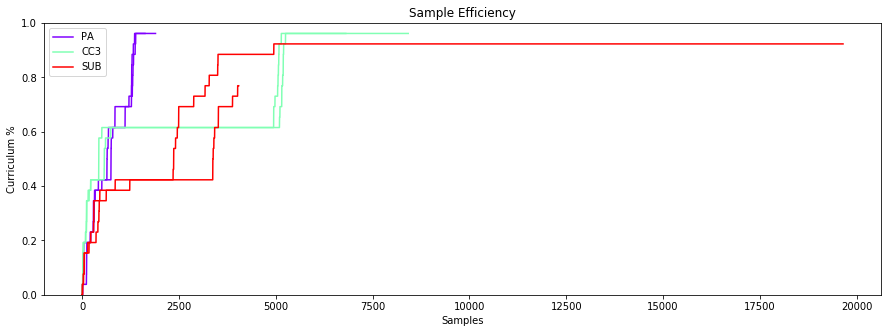

Found multiple files with name 821: ['T0821_PA_to_CC3_teacherPreActionAdvice, CartesianCorrections_SD_threshS0.99_threshAR0.6_threshAD0.6_lr0.0001_ent0.0001_1', 'EVAL_821_NOFINETUNE']
couldn't plot PA -> CC3 -> None


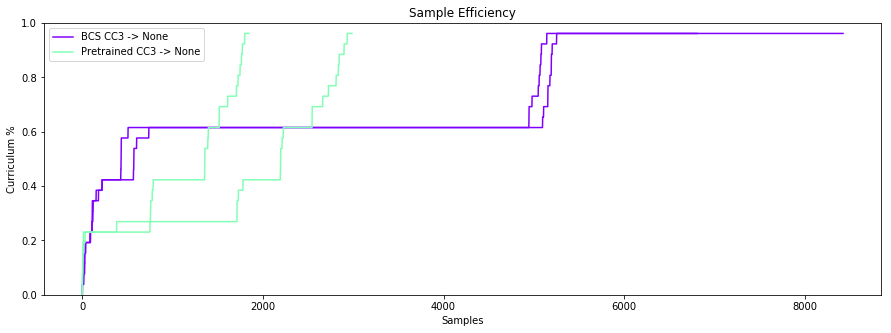

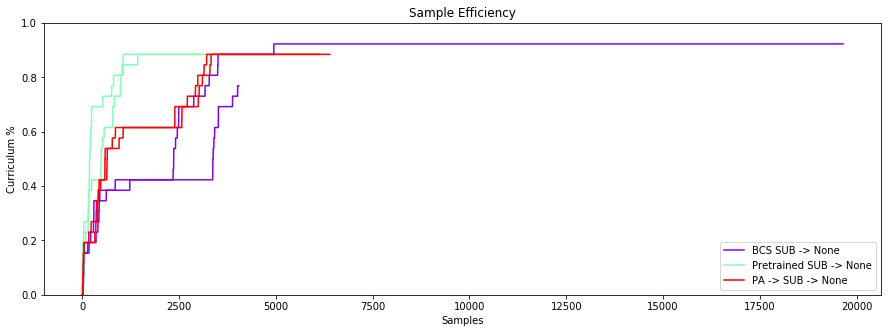

In [42]:
data_names = [ 
    (['845', '846'], 'PA'),
    (['847', '848'], 'CC3'),
    (['849', '850'], 'SUB'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['847', '848'], 'BCS CC3 -> None'),
    (['859', '860'], 'Pretrained CC3 -> None'),
    (['821', '822'], 'PA -> CC3 -> None'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['849', '850'], 'BCS SUB -> None'),
    (['861', '862'], 'Pretrained SUB -> None'),
    (['823', '824'], 'PA -> SUB -> None'),
]
plot_curriculum(data_names, 'samples')

BCS (oracle -> teacher) vs Pseudo-BCS (Pretrained PA --> Teacher) vs Bootstrap (PA --> Teacher)

Takeaway: bootstrapping from PA is almost as good as bootstrapping from the oracle~

Found multiple files with name 659: ['T0659_CURRICULUM1_CC3_BCS_teacherCartesianCorrections_SAME_SD_dense_threshS0.99_threshA0.6_lr0.0001_ent0.0001_currfnone_hot_2', 'EVAL_659_NOFINETUNE']
couldn't plot Oracle -> CC3
Found multiple files with name 851: ['T0851_CURRICULUM1_CC3_BCS_teacherPreActionAdvice, CartesianCorrections_SD_threshS0.99_threshAR0.6_threshAD0.6_lr0.0001_ent0.0001_1', 'EVAL_851_NOFINETUNE']
couldn't plot Pretrained PA -> CC3


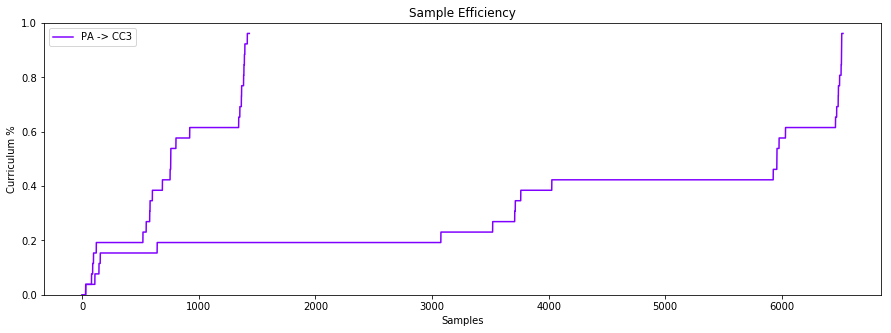

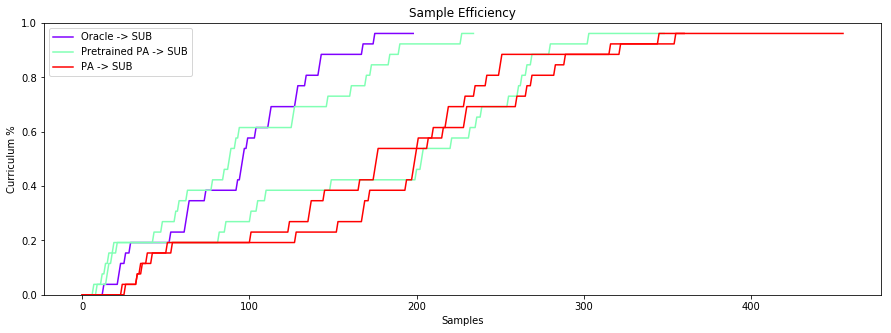

In [43]:
data_names = [ 
    (['659'], 'Oracle -> CC3'),
    (['851'], 'Pretrained PA -> CC3'),
    (['855', '856'], 'PA -> CC3'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['661'], 'Oracle -> SUB'),
    (['853', '854'], 'Pretrained PA -> SUB'),
    (['857', '858'], 'PA -> SUB'),
]
plot_curriculum(data_names, 'samples')


Distill with distribution less biased toward current level

Found multiple files with name 863: ['863', 'EVAL_863_NOFINETUNE']
couldn't plot CC3 .2 current
Found multiple files with name 821: ['T0821_PA_to_CC3_teacherPreActionAdvice, CartesianCorrections_SD_threshS0.99_threshAR0.6_threshAD0.6_lr0.0001_ent0.0001_1', 'EVAL_821_NOFINETUNE']
couldn't plot CC3 .5 current


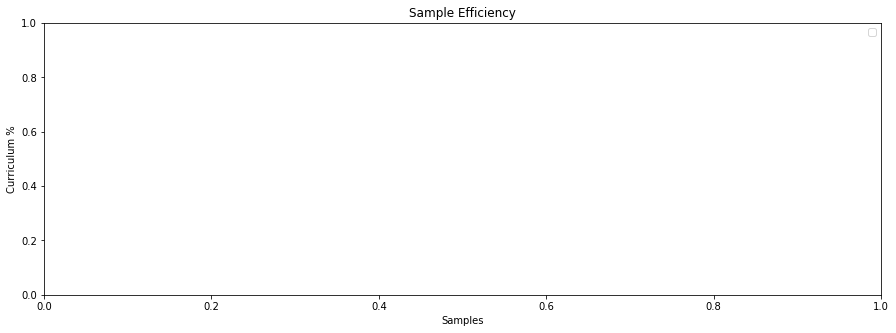

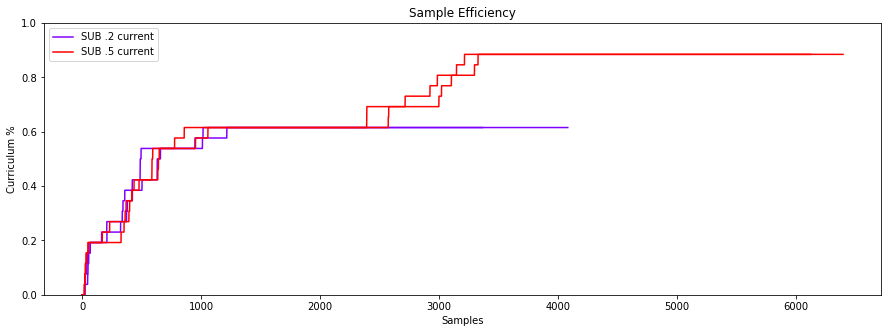

In [44]:

data_names = [ 
    (['863', '864'], 'CC3 .2 current'),
    (['821', '822'], 'CC3 .5 current'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['865', '866'], 'SUB .2 current'),
    (['823', '824'], 'SUB .5 current'),
]
plot_curriculum(data_names, 'samples')

Way more distillation itrs

Found multiple files with name 821: ['T0821_PA_to_CC3_teacherPreActionAdvice, CartesianCorrections_SD_threshS0.99_threshAR0.6_threshAD0.6_lr0.0001_ent0.0001_1', 'EVAL_821_NOFINETUNE']
couldn't plot CC3 Normal
Found multiple files with name 869: ['869', 'EVAL_869_NOFINETUNE']
couldn't plot CC3 More Itrs


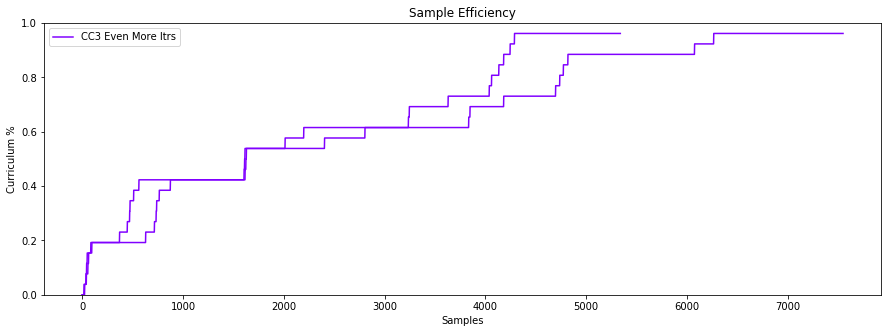

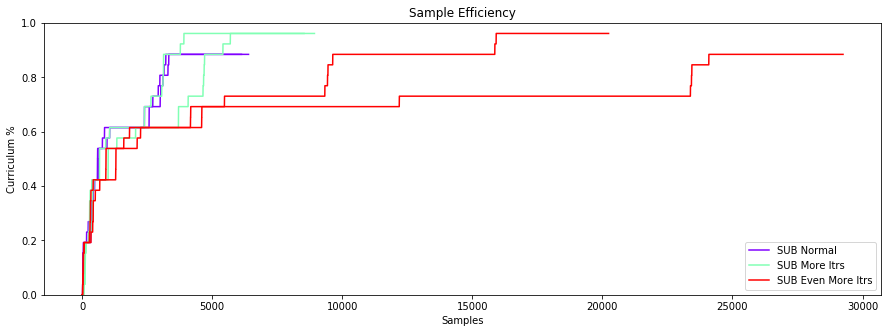

In [45]:

data_names = [ 
    (['821', '822'], 'CC3 Normal'),
    (['869', '870'], 'CC3 More Itrs'),
    (['899', '900'], 'CC3 Even More Itrs'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'SUB Normal'),
    (['871', '872'], 'SUB More Itrs'),
    (['901', '902'], 'SUB Even More Itrs'),
]
plot_curriculum(data_names, 'samples')

High accuracy + run forever (goal is to see if generalization improves)

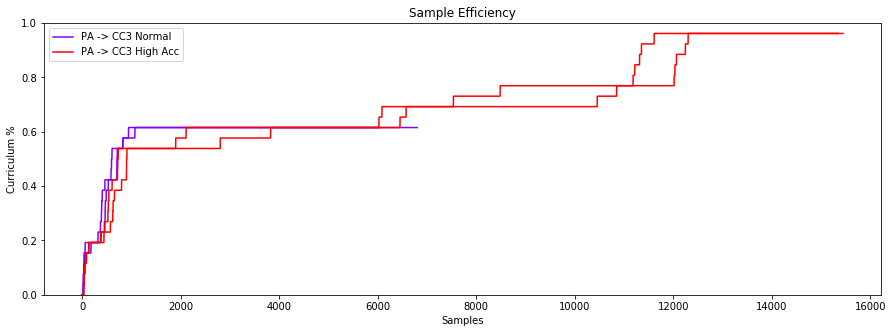

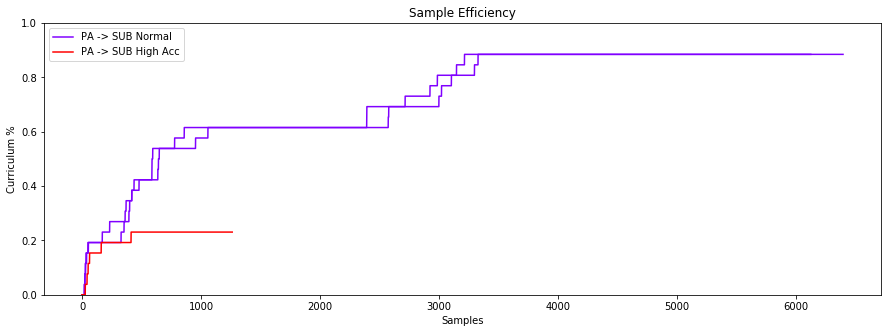

In [51]:
data_names = [ 
    (['0821', '0822'], 'PA -> CC3 Normal'),
    (['0873', '0874'], 'PA -> CC3 High Acc'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'PA -> SUB Normal'),
    (['875', '876'], 'PA -> SUB High Acc'),
]
plot_curriculum(data_names, 'samples')

Does increasing the acc threshold when we're using PA help?

Found multiple files with name 821: ['T0821_PA_to_CC3_teacherPreActionAdvice, CartesianCorrections_SD_threshS0.99_threshAR0.6_threshAD0.6_lr0.0001_ent0.0001_1', 'EVAL_821_NOFINETUNE']
couldn't plot PA -> CC3 Normal


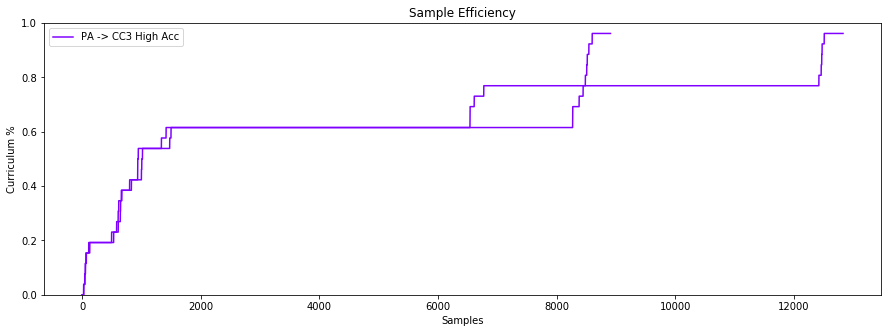

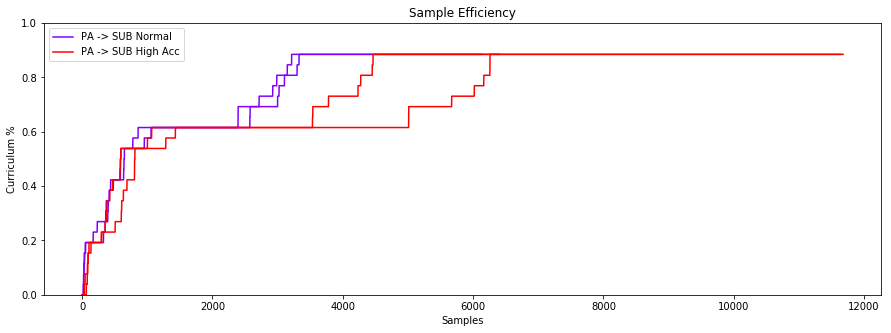

In [47]:
data_names = [ 
    (['821', '822'], 'PA -> CC3 Normal'),
    (['0903', '0904'], 'PA -> CC3 High Acc'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'PA -> SUB Normal'),
    (['0905', '0906'], 'PA -> SUB High Acc'),
]
plot_curriculum(data_names, 'samples')

Does increasing LR help?

Found multiple files with name 821: ['T0821_PA_to_CC3_teacherPreActionAdvice, CartesianCorrections_SD_threshS0.99_threshAR0.6_threshAD0.6_lr0.0001_ent0.0001_1', 'EVAL_821_NOFINETUNE']
couldn't plot PA -> CC3 Normal


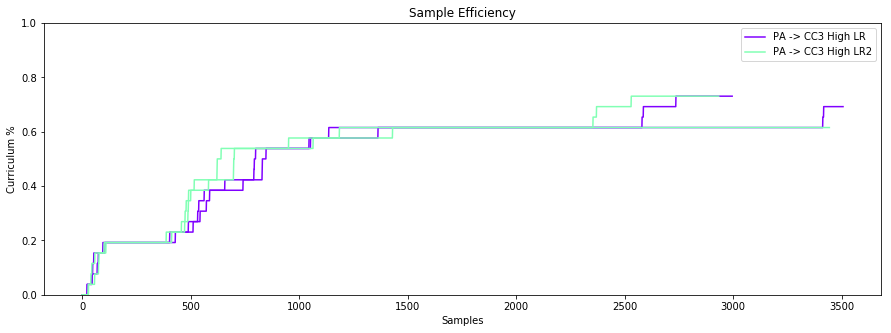

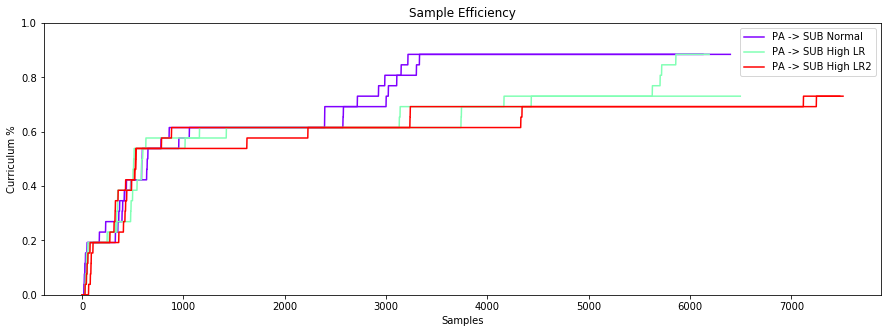

In [48]:
data_names = [ 
    (['821', '822'], 'PA -> CC3 Normal'),
    (['0907', '0908'], 'PA -> CC3 High LR'),
    (['0911', '0912'], 'PA -> CC3 High LR2'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'PA -> SUB Normal'),
    (['0909', '0910'], 'PA -> SUB High LR'),
    (['0913', '0914'], 'PA -> SUB High LR2'),
]
plot_curriculum(data_names, 'samples')

Does high acc + low entropy help?

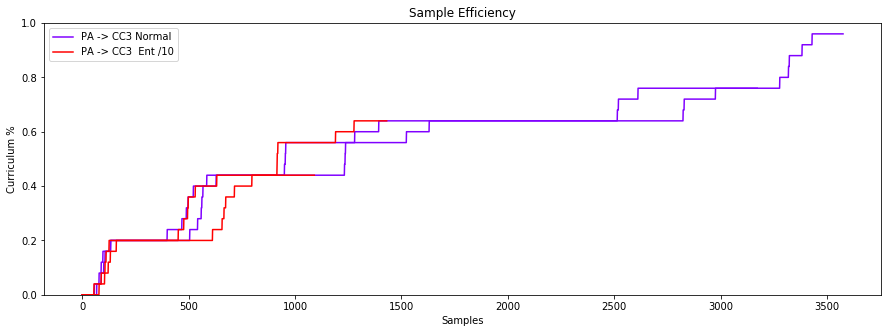

In [62]:
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
#     (['0931', '0932'], 'PA -> CC3 Help'), # Third best; cheats by using PA a lot
#     (['0933', '0934'], 'PA -> CC3 Help + RL Acc .9'), # Second Best; cheats by using PA a lot
#     (['0935', '0936'], 'PA -> CC3 -> None'), # Not great; stoppable
#     (['0937', '0938'], 'PA -> CC3 -> None + RL Acc .9'), # Best; cheats by using PA a lot
#     (['0939', '0940'], 'PA -> CC3 -> None + High PA Acc'), # Not great; stoppable
    (['0955', '0956'], 'PA -> CC3  Ent /10'),
#     (['0963', '0964'], 'PA -> CC3 -> None + RL Acc .9 Ent /10'), # Bad; stoppable, but we should analyze
]
plot_curriculum(data_names, 'samples')

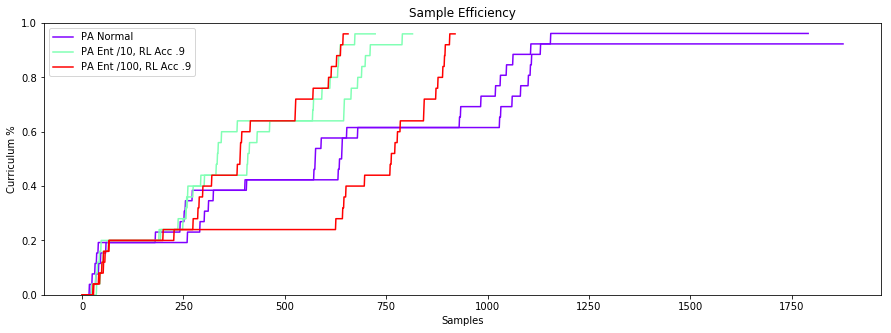

In [61]:
data_names = [ 
    (['867', '868'], 'PA Normal'),
    (['0953', '0954'], 'PA Ent /10, RL Acc .9'),
    (['0957', '0958'], 'PA Ent /100, RL Acc .9'),
]
plot_curriculum(data_names, 'samples')

Combining argmax, sample, logits

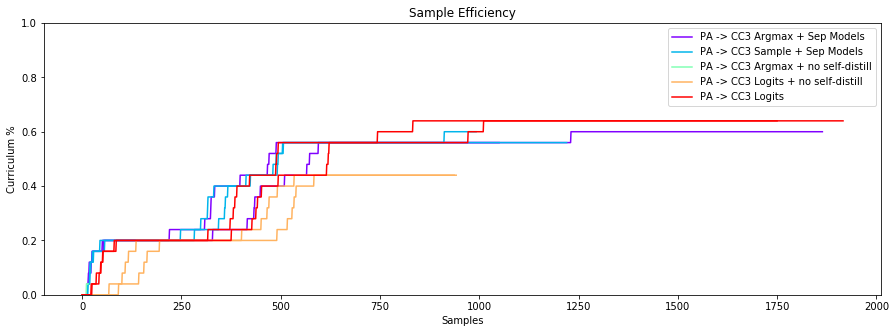

In [64]:
data_names = [ 
#     (['0967', '0968'], 'PA -> CC3 Argmax'), # BAD; all others are basically the same
    (['0969', '0970'], 'PA -> CC3 Argmax + Sep Models'),
    (['0971', '0972'], 'PA -> CC3 Sample + Sep Models'),
    (['0973', '0974'], 'PA -> CC3 Argmax + no self-distill'),
    (['0975', '976'], 'PA -> CC3 Logits + no self-distill'),
    (['977', '978'], 'PA -> CC3 Logits'),
]
plot_curriculum(data_names, 'samples')

# End